# Parallel Multi-Modal Terrain Roughness Classification  
CSYE 7105: High Performance Parallel Machine Learning & AI  
Team 11: Sathvik Vadavatha, Shushil Girish

This notebook implements the end-to-end pipeline for our final project:

- Dataset: Off-Road Terrain Dataset for Autonomous Vehicles (Kaggle)
- Goal: Predict terrain roughness from synchronized **images + sensor data(Accelerometer and Gyroscope)**
- Focus: Compare **sequential vs parallel** implementations at multiple stages:
  - Image–sensor alignment with CPU multiprocessing,Multi-Threading and Dask Implementation
  - Sensor feature extraction with Dask / joblib
  - Image embedding extraction and model training on GPU (CUDA)
  - Image embedding extraction using ResNet pretrained model using **Distributed Data Parallel** with nccl and gloo collective communication library
- Output: Models, timing measurements, speedup and efficiency plots that support
  the Final Report sections: Methodology and Results & Analysis.


## 1) Setup and Utilities

This cell initializes the core environment and prepares the notebook for 
CPU multiprocessing, joblib threading, Dask parallelism, and PyTorch 
Distributed Data Parallel (D
---

### **Imports**
This section loads all major libraries used throughout the pipeline:

- **Data / ML:** `numpy`, `pandas`, `matplotlib`, `seaborn`, `sklearn`
- **Parallelism:**  
  - `multiprocessing` for process-level parallelism  
  - `joblib` for thread-level parallelism  
  - `dask` (`dask.dataframe`, `delayed`) for partition-based execution
- **Deep Learning:**  
  - `torch`, `torch.nn`, `torchvision`  
  - `PIL.Image` for image I/O
- **Distributed Training (DDP):**  
  - `torch.distributed` with support for **NCCL** (GPU) and **GLOO** (CPU)

These imports enable sequential, CPU-parallel, distributed, and GPU-accelerated stages used in the notebook.

---

### **Project Paths**
We define and display:

- `BASE_DIR` → notebook directory  
- `DATA_DIR` → dataset root  
- `IMG_ROOT` → image folder  
- `SENSOR_ROOT` → sensor CSV folders  
- `LABEL_CSV` → image label file  

This ensures downstream loading and alignmentions access consistent paths.

---

### **Timing Utility**
A robust `@timed` decorator is defined to:

- Execute any function  
- Measure wall-clock runtime  
- Return `(result, elapsed_time)`

Used for benchmarking:
- Sequential vs multiprocessing
- Joblib threads  
- Dask part  
- CPU vs GPU vs DDP embedding extraction

---

### **Timestamp Parsing**
`parse_image_timestamp()` converts filenames like:
 can fix the path before running the rest of the notebook.


In [1]:
# 1. SETUP AND UTILITIES

import os
import time
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

import dask
import dask.dataframe as dd
# from dask import delayed

print("Dask version:", dask.__version__)
import re

# Paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_LABEL_DIR = os.path.join(DATA_DIR, "ImageLabels")
IMG_ROOT = os.path.join(DATA_DIR, "Images", "Images")
SENSOR_ROOT = os.path.join(DATA_DIR, "SensorData")

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("IMG_ROOT:", IMG_ROOT)
print("SENSOR_ROOT:", SENSOR_ROOT)

if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError("No 'data' directory found next to this notebook.")

def timed(fn):
    """Simple decorator to time a function and return (result, seconds)."""
    def wrapper(*args, **kwargs):
        start = time.time()
        result = fn(*args, **kwargs)
        end = time.time()
        return result, end - start
    return wrapper

_TS_PATTERN = re.compile(r"(?P<sec>\d+)s(?P<ms>\d+)ms")

def parse_image_timestamp(filename: str) -> float:
    """
    Parse names like '964868548s701ms.jpg' into seconds as a float.

    Works even if there is extra text around the pattern, by searching
    for the first '<digits>s<digits>ms' substring.
    """
    base = os.path.basename(str(filename))
    stem = os.path.splitext(base)[0]

    m = _TS_PATTERN.search(stem)
    if not m:
        raise ValueError(f"Could not parse timestamp from stem='{stem}'")

    sec = int(m.group("sec"))
    ms = int(m.group("ms"))
    return sec + ms / 1000.0

# Device and GPU diagnostics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("CPU cores available:", cpu_count())

print("torch version:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print("Number of GPUs visible to PyTorch:", gpu_count)
    for i in range(gpu_count):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA GPU visible to PyTorch. Running everything on CPU.")


Dask version: 2025.10.0
BASE_DIR: /courses/CSYE7105.202610/students/vadavatha.s/Final_Project
DATA_DIR: /courses/CSYE7105.202610/students/vadavatha.s/Final_Project/data
IMG_ROOT: /courses/CSYE7105.202610/students/vadavatha.s/Final_Project/data/Images/Images
SENSOR_ROOT: /courses/CSYE7105.202610/students/vadavatha.s/Final_Project/data/SensorData
Using device: cuda
CPU cores available: 28
torch version: 2.5.1+cu121
torch.cuda.is_available(): True
Number of GPUs visible to PyTorch: 4
  GPU 0: Tesla P100-PCIE-12GB
  GPU 1: Tesla P100-PCIE-12GB
  GPU 2: Tesla P100-PCIE-12GB
  GPU 3: Tesla P100-PCIE-12GB


The setup cell confirms that the environment is ready:

- `BASE_DIR` is `/courses/CSYE7105.202610/students/vadavatha.s/Final_Project`, and the `data` subfolder is found successfully.
- `IMG_ROOT` and `SENSOR_ROOT` both point to the expected image and sensor directories under `data/`.

The hardware diagnostics show:

- `device: cuda` with `torch.cuda.is_available() == True`
- 28 CPU cores are available on this node.
- 4 visible NVIDIA Tesla P100 GPUs are detected.

This means:

- We can benchmark both **CPU-only** and **GPU-accelerated** stages in the same notebook.
- Later sections (ResNet18 embeddings and MLP training) will run on the GPU, while multiprocessing and joblib will use all available CPU cores.

With this setup in place, we can now move on to loading labels and building a unified view of images and roughness scores.


## 2. Labels and image paths

In this section we connect the image-level labels to the actual JPEG files on disk and derive a numeric timestamp for every image.

Steps in this cell:

- Load the `tsm_1_labels.csv` file from `data/ImageLabels/`.
- Inspect the label DataFrame shape, column names, and class distribution for the 3-class roughness label `tsm1_k3`.
- Recursively index all image files in `data/Images/Images/<date>/` and build a dictionary that maps `filename.jpg` to its absolute path.
- Attach image paths to `labels_df` via the `image` column and report any missing files.
- Drop rows where the corresponding image file is not found so that later stages work only on valid samples.
- Parse the image filenames into numeric timestamps `img_ts` using `parse_image_timestamp`, which converts names like `964868548s701ms.jpg` into seconds as a float.

This prepares a clean table where each row represents one labeled image with a resolved path and a comparable timestamp that we can later align to time series sensor windows.


In [2]:
# 2. LABELS + IMAGE PATHS

# Load tsm_1 labels (Can switch to tsm_2 later for experiments)
tsm1_path = os.path.join(IMG_LABEL_DIR, "tsm_1_labels.csv")
labels_df = pd.read_csv(tsm1_path)

print("tsm_1_labels shape:", labels_df.shape)
display(labels_df.head())

print("\nLabel columns:", labels_df.columns.tolist())
print("\nClass counts (k=3 example):")
print(labels_df["tsm1_k3"].value_counts())

# Build a mapping from image filename -> full path across all date folders
image_paths = {}
for date_folder in sorted(os.listdir(IMG_ROOT)):
    full_dir = os.path.join(IMG_ROOT, date_folder)
    if not os.path.isdir(full_dir):
        continue
    for fname in os.listdir(full_dir):
        if fname.lower().endswith(".jpg"):
            image_paths[fname] = os.path.join(full_dir, fname)

print(f"Total images indexed: {len(image_paths):,}")

# Attach paths and timestamps to labels_df
labels_df["img_path"] = labels_df["image"].map(image_paths)

missing = labels_df["img_path"].isna().sum()
print(f"Images with missing files: {missing}")

# Drop rows without image files
labels_df = labels_df.dropna(subset=["img_path"]).reset_index(drop=True)

# Add numeric timestamp column
labels_df["img_ts"] = labels_df["image"].apply(parse_image_timestamp)

print("\nAfter attaching paths:")
print(labels_df[["image", "img_path", "img_ts", "tsm1_k2", "tsm1_k3", "tsm1_k4"]].head())

tsm_1_labels shape: (7068, 5)


,image,tsm1_original,tsm1_k2,tsm1_k3,tsm1_k4
0,964868548s701ms.jpg,3.0,1.0,1.0,2.0
1,964868549s702ms.jpg,1.0,0.0,1.0,1.0
2,964868568s721ms.jpg,2.0,0.0,1.0,1.0
3,964868569s722ms.jpg,0.0,0.0,0.0,0.0
4,964868571s724ms.jpg,1.0,0.0,0.0,1.0



Label columns: ['image', 'tsm1_original', 'tsm1_k2', 'tsm1_k3', 'tsm1_k4']

Class counts (k=3 example):
tsm1_k3
0.0    3750
1.0    2533
2.0     785
Name: count, dtype: int64
Total images indexed: 12,730
Images with missing files: 0

After attaching paths:
                 image                                           img_path  \
0  964868548s701ms.jpg  /courses/CSYE7105.202610/students/vadavatha.s/...   
1  964868549s702ms.jpg  /courses/CSYE7105.202610/students/vadavatha.s/...   
2  964868568s721ms.jpg  /courses/CSYE7105.202610/students/vadavatha.s/...   
3  964868569s722ms.jpg  /courses/CSYE7105.202610/students/vadavatha.s/...   
4  964868571s724ms.jpg  /courses/CSYE7105.202610/students/vadavatha.s/...   

         img_ts  tsm1_k2  tsm1_k3  tsm1_k4  
0  9.648685e+08      1.0      1.0      2.0  
1  9.648685e+08      0.0      1.0      1.0  
2  9.648686e+08      0.0      1.0      1.0  
3  9.648686e+08      0.0      0.0      0.0  
4  9.648686e+08      0.0      0.0      1.0  


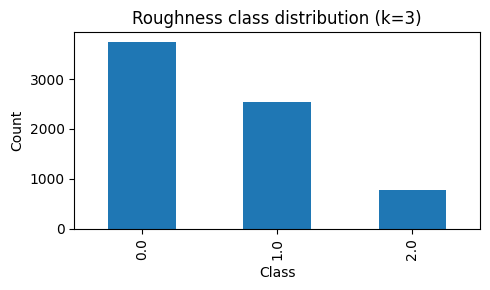

In [3]:
# 2b. SIMPLE LABEL HISTOGRAM

fig, ax = plt.subplots(figsize=(5, 3))
labels_df["tsm1_k3"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Roughness class distribution (k=3)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


### Label Summary

The labels table is now fully enriched with:

- Absolute image paths  
- Parsed timestamps (float seconds)  
- Clean, non-missing entries for every usable image  

With **7068 valid image-label pairs**, this forms the core dataset for image embedding extraction and multimodal sensor fusion.

The timestamp column (`img_ts`) will later be used to align sensors with ±0.5 second windows, and the class labels (`tsm1_k3` in this notebook run) provide the ground truth targets for both sensor-only and fusi

And looking from the histogram , we can observe class 0 is more dominant compared to class 2 . This means there is **class imbalance** in the dataset . We need to be mindful about this and use various techniques while training model based on this label columnon models.

Next, we will move to **image timestamp parsing validation and visualization**, followed by **sensor data loading**.


# 3. Sensor Consolidation

The off-road dataset includes multiple sensor modalities recorded across several driving sessions.  
Each session directory inside `data/SensorData/` contains its own accelerometer, gyroscope, magnetometer, and GPS CSV files.

We begin by loading and unifying the **accelerometer** data:

- Each session contains `accelerometer_calibrated_split.csv`
- Timestamps are stored as `utc_s (s)` and `utc_ms (ms)`
- We convert these into a single floating-point `ts` column
- Sensor axes (`x`, `y`, `z`) are stored in calibrated units
- Each row is tagged with a `session_id`, allowing us to merge across sessions later

We then scan every session folder under `SENSOR_ROOT`, load its accelerometer file, and concatenate all of them into a single global DataFrame.

This dataset will later be aligned with image timestamps to extract statistical and spectral features in ±0.5s windows.


## a. Accelerometer Data Merge

In [4]:
# 3. SENSOR CONSOLIDATION

ACC_FILE = "accelerometer_calibrated_split.csv"  # file name inside each session


def load_accelerometer_session(session_dir: str) -> pd.DataFrame:
    """
    Load one session's calibrated accelerometer CSV and return a DataFrame with:
    - session_id
    - ts (float seconds)
    - calibrated_accel_x, calibrated_accel_y, calibrated_accel_z
    """
    acc_path = os.path.join(session_dir, ACC_FILE)
    df = pd.read_csv(acc_path)
    
    # Standard column names from Kaggle docs
    # utc_s (s), utc_ms (ms), calibrated_accel_x (g), calibrated_accel_y (g), calibrated_accel_z (g)
    if "utc_s (s)" not in df.columns:
        raise ValueError(f"Unexpected columns in {acc_path}. Got {df.columns[:10]}")

    ts = df["utc_s (s)"].astype(float) + df["utc_ms (ms)"].astype(float) / 1000.0
    
    out = pd.DataFrame({
        "ts": ts,
        "accel_x": df["calibrated_accel_x (g)"],
        "accel_y": df["calibrated_accel_y (g)"],
        "accel_z": df["calibrated_accel_z (g)"],
    })
    session_id = os.path.basename(session_dir.rstrip("/"))
    out["session_id"] = session_id
    return out


@timed
def load_all_accelerometer(sensor_root: str) -> pd.DataFrame:
    """Concatenate all session accelerometer data."""
    frames = []
    for session_folder in sorted(os.listdir(sensor_root)):
        session_dir = os.path.join(sensor_root, session_folder)
        if not os.path.isdir(session_dir):
            continue
        print("Loading session:", session_folder)
        frames.append(load_accelerometer_session(session_dir))
    full = pd.concat(frames, axis=0, ignore_index=True)
    full = full.sort_values("ts").reset_index(drop=True)
    return full


acc_df, acc_load_time = load_all_accelerometer(SENSOR_ROOT)
print(f"\nAccelerometer shape: {acc_df.shape}, load time: {acc_load_time:.2f}s")
display(acc_df.head())


Loading session: 2020-07-28-06-01-11
Loading session: 2020-09-23-16-10-10
Loading session: 2020-09-24-12-07-41
Loading session: 2020-09-29-09-46-42
Loading session: 2020-10-02-10-17-05

Accelerometer shape: (1481190, 5), load time: 2.05s


,ts,accel_x,accel_y,accel_z,session_id
0,9.648685e+08,0.192383,-0.096191,0.905273,2020-07-28-06-01-11
1,9.648685e+08,0.188965,-0.100098,0.929688,2020-07-28-06-01-11
2,9.648685e+08,0.195801,-0.098633,0.987793,2020-07-28-06-01-11
3,9.648685e+08,0.210449,-0.091309,1.016602,2020-07-28-06-01-11
4,9.648685e+08,0.230957,-0.083496,0.992676,2020-07-28-06-01-11


## b. Accelerometer Distribution

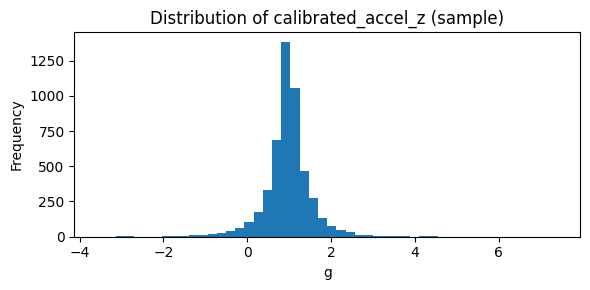

In [5]:


fig, ax = plt.subplots(figsize=(6, 3))
acc_df["accel_z"].sample(5000, random_state=0).plot(kind="hist", bins=50, ax=ax)
ax.set_title("Distribution of calibrated_accel_z (sample)")
ax.set_xlabel("g")
plt.tight_layout()
plt.show()


The complete accelerometer table is now loaded and time-ordered across all driving sessions.

This unified DataFrame provides:

- A single global timeline (`ts`)
- Calibrated accelerometer values for all samples
- Session identifiers for tracking source folders
- A foundation for windowed fearactionture ext

Also from the histogram of the calibrated_accel_z , we can observe the distribution is more dense in between raction

The load time metric from the `@timed` decorator allows us to benchmark efficiency across different I/O configurations.  

Next, we will repeat this consolidation step for **gyroscope**, **magnetometer**, and **GPS** streams before moving into parallelized alignment.


# 4. Stage 1: Alignment (sequential and multiprocessing)

In this stage we begin the core performance work for the sensor pipeline.  
Each image has a timestamp, and we extract accelerometer statistics from a fixed time window centered around it. This gives us a basic measure of motion intensity and variability directly linked to the captured terrain.

To measure speedups, we first build a **sequential baseline** for alignment and feature extraction.  
This uses a simple Python loop and processes each image one at a time.

Once the baseline is established, we introduce **multiprocessing**, splitting the label table into chunks and evaluating window features in parallel. This allows us to compare:

- single-process execution  
- multi-process execution with varying worker counts
- mult-threading with joblib module: `Parallel`
- dask task scheduling 
- resulting speedup and efficiency curves  

The goal is to understand how far alignment can scale before memory pressure or I/O overhead starts to dominate.


In [6]:
# 4. STAGE 1: ALIGNMENT (SEQUENTIAL VS MULTIPROCESSING) ON FULL DATA

# Precompute arrays for faster lookup
sensor_ts = acc_df["ts"].values
acc_z = acc_df["accel_z"].values

def compute_window_features(ts_center: float, window_size: float = 1.0):
    """
    Compute simple stats of accel_z in a window around ts_center.
    window_size is total width (seconds), so +/- window_size/2.
    """
    half = window_size / 2.0
    left = ts_center - half
    right = ts_center + half
    mask = (sensor_ts >= left) & (sensor_ts <= right)
    if not np.any(mask):
        return {
            "acc_z_mean": np.nan,
            "acc_z_std": np.nan,
            "acc_z_max": np.nan,
            "acc_z_min": np.nan,
            "acc_z_count": 0,
        }
    vals = acc_z[mask]
    return {
        "acc_z_mean": float(np.mean(vals)),
        "acc_z_std": float(np.std(vals)),
        "acc_z_max": float(np.max(vals)),
        "acc_z_min": float(np.min(vals)),
        "acc_z_count": int(len(vals)),
    }


def align_sequential(df: pd.DataFrame, window_size: float = 1.0) -> pd.DataFrame:
    """Sequential baseline for alignment + feature extraction."""
    records = []
    for _, row in df.iterrows():
        feats = compute_window_features(row["img_ts"], window_size)
        feats["image"] = row["image"]
        feats["tsm1_k3"] = row["tsm1_k3"]  # choose one label scheme here
        records.append(feats)
    return pd.DataFrame(records)


@timed
def run_align_sequential(df: pd.DataFrame, window_size: float = 1.0):
    return align_sequential(df, window_size)


print("Running sequential alignment on FULL labels_df...")
aligned_seq_df, t_seq = run_align_sequential(labels_df, window_size=1.0)
print(f"Sequential alignment on {len(labels_df)} images took {t_seq:.2f}s")
display(aligned_seq_df.head())


Running sequential alignment on FULL labels_df...
Sequential alignment on 7068 images took 15.09s


,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,acc_z_count,image,tsm1_k3
0,0.983960,0.666051,2.019531,-1.242188,100,964868548s701ms.jpg,1.0
1,0.925485,0.738846,2.454102,-0.552246,99,964868549s702ms.jpg,1.0
2,0.997194,0.432789,2.969727,-0.204590,99,964868568s721ms.jpg,1.0
3,0.980977,0.768349,3.460449,-1.050293,99,964868569s722ms.jpg,0.0
4,1.024575,0.175011,1.533203,0.445801,100,964868571s724ms.jpg,0.0


The sequential pass gives us a clear baseline runtime for the full dataset.  
With over seven thousand images, this step is slow enough to meaningfully highlight the benefits of parallel processing.

The head of the aligned table confirms that window statistics are computed correctly and that each row now contains both the roughness label and the accelerometer-derived features.  
This forms the foundation for the multiprocessing comparison that follows.


## Multiprocessing alignment

Here we divide the label table into multiple chunks and run the alignment function in parallel using Python’s `multiprocessing.Pool`.

By varying the number of workers from 1 to 16, we can observe:

- how runtime decreases  
- where diminishing returns begin  
- how efficiency behaves as worker counts grow  

After each run, the outputs are concatenated back into a single aligned table so downstream modeling remains unchanged.



Running multiprocessing alignment with 1 workers on FULL labels_df...


/home/vadavatha.s/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  Time: 15.17s, aligned shape: (7068, 7)

Running multiprocessing alignment with 2 workers on FULL labels_df...


/home/vadavatha.s/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  Time: 7.68s, aligned shape: (7068, 7)

Running multiprocessing alignment with 4 workers on FULL labels_df...


/home/vadavatha.s/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  Time: 3.93s, aligned shape: (7068, 7)

Running multiprocessing alignment with 8 workers on FULL labels_df...


/home/vadavatha.s/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  Time: 2.49s, aligned shape: (7068, 7)

Running multiprocessing alignment with 16 workers on FULL labels_df...


/home/vadavatha.s/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  Time: 2.24s, aligned shape: (7068, 7)


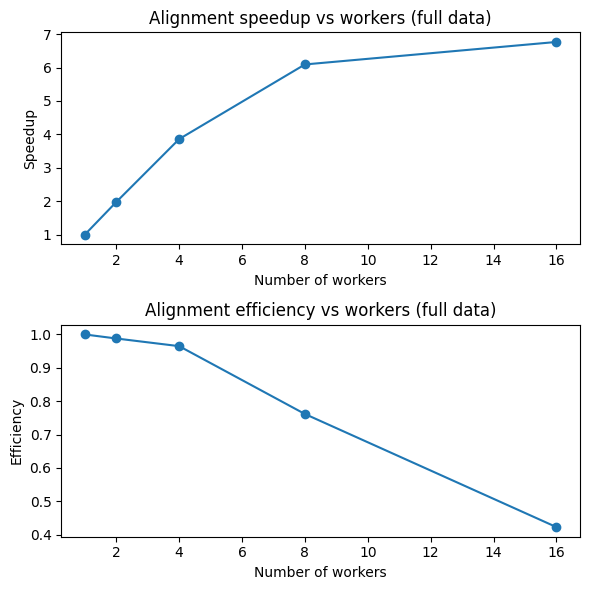

In [7]:
# 4b. MULTIPROCESSING ALIGNMENT ON FULL DATA

def _align_chunk(chunk: pd.DataFrame, window_size: float = 1.0):
    out = align_sequential(chunk, window_size)
    return out


@timed
def run_align_multiprocessing(df: pd.DataFrame, window_size: float = 1.0, n_workers: int = 4):
    chunks = np.array_split(df, n_workers)
    with Pool(processes=n_workers) as pool:
        results = pool.starmap(_align_chunk, [(c, window_size) for c in chunks])
    aligned = pd.concat(results, ignore_index=True)
    return aligned


worker_list = [1, 2, 4, 8, 16]
times = []

for w in worker_list:
    print(f"\nRunning multiprocessing alignment with {w} workers on FULL labels_df...")
    aligned_mp_df, t_mp = run_align_multiprocessing(labels_df, window_size=1.0, n_workers=w)
    times.append(t_mp)
    print(f"  Time: {t_mp:.2f}s, aligned shape: {aligned_mp_df.shape}")

# Speedup and efficiency plots
T1 = times[0]  # time at 1 worker
speedups = [T1 / t for t in times]
efficiencies = [s / p for s, p in zip(speedups, worker_list)]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

axes[0].plot(worker_list, speedups, marker="o")
axes[0].set_title("Alignment speedup vs workers (full data)")
axes[0].set_xlabel("Number of workers")
axes[0].set_ylabel("Speedup")

axes[1].plot(worker_list, efficiencies, marker="o")
axes[1].set_title("Alignment efficiency vs workers (full data)")
axes[1].set_xlabel("Number of workers")
axes[1].set_ylabel("Efficiency")

plt.tight_layout()
plt.show()

The results show strong gains up to about eight workers.  
Beyond that point, contention on shared memory and I/O bandwidth begins to reduce efficiency, and speedups taper off.

This behavior is typical for workloads where each worker repeatedly accesses the same large arrays in memory, and it helps us choose a sensible worker count for the rest of the pipeline.

With alignment complete, we now extend the evaluation to a richer feature set and move from processes to threads using joblib.


# 5. Stage 2: Thread-parallel feature extraction (joblib)

After evaluating process-based parallelism, we explore thread-level parallelism using joblib.  
This approach avoids the overhead of copying large arrays across worker processes and can be faster when the workload is partially I/O bound or lightly CPU bound.

Here we compute an expanded set of accelerometer features, including percentiles and additional summary statistics. These features more accurately reflect terrain irregularities within each window.

We benchmark `n_jobs` from 1 to 16 to compare:

- thread-based scaling  
- efficiency relative to worker count  
- whether joblib saturates earlier than multiprocessing  



Joblib feature extraction on FULL labels_df with n_jobs=1
  Time: 16.77s, features shape: (7068, 9)

Joblib feature extraction on FULL labels_df with n_jobs=2
  Time: 15.57s, features shape: (7068, 9)

Joblib feature extraction on FULL labels_df with n_jobs=4
  Time: 9.33s, features shape: (7068, 9)

Joblib feature extraction on FULL labels_df with n_jobs=8
  Time: 6.94s, features shape: (7068, 9)

Joblib feature extraction on FULL labels_df with n_jobs=16
  Time: 5.84s, features shape: (7068, 9)


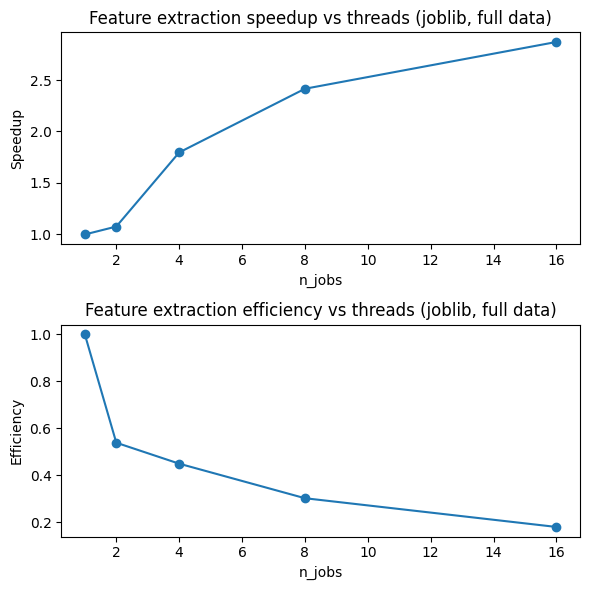

sensor_feature_df shape (full data): (7068, 9)


,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,acc_z_p95,acc_z_p05,acc_z_count,image,label_k3
0,0.983960,0.666051,2.019531,-1.242188,1.909839,-0.258179,100,964868548s701ms.jpg,1.0
1,0.925485,0.738846,2.454102,-0.552246,2.062207,-0.277051,99,964868549s702ms.jpg,1.0
2,0.997194,0.432789,2.969727,-0.204590,1.688184,0.312012,99,964868568s721ms.jpg,1.0
3,0.980977,0.768349,3.460449,-1.050293,2.229004,-0.446338,99,964868569s722ms.jpg,0.0
4,1.024575,0.175011,1.533203,0.445801,1.327246,0.774536,100,964868571s724ms.jpg,0.0


In [8]:
# 5. STAGE 2: THREAD PARALLEL FEATURE EXTRACTION (JOBLIB) ON FULL DATA

def compute_rich_features(ts_center: float, window_size: float = 1.0):
    """
    Extended feature set for accel_z. Can later add gyroscope, speed, etc.
    """
    half = window_size / 2.0
    left = ts_center - half
    right = ts_center + half
    mask = (sensor_ts >= left) & (sensor_ts <= right)
    if not np.any(mask):
        return {
            "acc_z_mean": np.nan,
            "acc_z_std": np.nan,
            "acc_z_max": np.nan,
            "acc_z_min": np.nan,
            "acc_z_p95": np.nan,
            "acc_z_p05": np.nan,
            "acc_z_count": 0,
        }
    vals = acc_z[mask]
    return {
        "acc_z_mean": float(np.mean(vals)),
        "acc_z_std": float(np.std(vals)),
        "acc_z_max": float(np.max(vals)),
        "acc_z_min": float(np.min(vals)),
        "acc_z_p95": float(np.percentile(vals, 95)),
        "acc_z_p05": float(np.percentile(vals, 5)),
        "acc_z_count": int(len(vals)),
    }


@timed
def extract_features_joblib(df: pd.DataFrame, window_size: float = 1.0, n_jobs: int = 4):
    def process_row(row):
        feats = compute_rich_features(row["img_ts"], window_size)
        feats["image"] = row["image"]
        feats["label_k3"] = row["tsm1_k3"]
        return feats

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(process_row)(row) for _, row in df.iterrows()
    )
    return pd.DataFrame(results)


job_counts = [1, 2, 4, 8, 16]
job_times = []

for n in job_counts:
    print(f"\nJoblib feature extraction on FULL labels_df with n_jobs={n}")
    features_df, t_job = extract_features_joblib(labels_df, window_size=1.0, n_jobs=n)
    job_times.append(t_job)
    print(f"  Time: {t_job:.2f}s, features shape: {features_df.shape}")

T1_job = job_times[0]
speedups_job = [T1_job / t for t in job_times]
eff_job = [s / p for s, p in zip(speedups_job, job_counts)]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

axes[0].plot(job_counts, speedups_job, marker="o")
axes[0].set_title("Feature extraction speedup vs threads (joblib, full data)")
axes[0].set_xlabel("n_jobs")
axes[0].set_ylabel("Speedup")

axes[1].plot(job_counts, eff_job, marker="o")
axes[1].set_title("Feature extraction efficiency vs threads (joblib, full data)")
axes[1].set_xlabel("n_jobs")
axes[1].set_ylabel("Efficiency")

plt.tight_layout()
plt.show()

# Use the features from the last (largest n_jobs) run as the main table
sensor_feature_df = features_df.dropna().reset_index(drop=True)
print("sensor_feature_df shape (full data):", sensor_feature_df.shape)
display(sensor_feature_df.head())


The joblib runs show modest improvement with more threads, but the gains taper off much earlier compared to multiprocessing.  
This reflects the mixed workload: some operations are CPU heavy, while others are constrained by memory and per-row Python overhead.

The resulting table gives us a cleaner and more expressive set of sensor features that will later be combined with image embeddings during fusion.


# 5b. Dask Distributed Task Scheduling


Section 5 showed that joblib thread-based parallelism degraded significantly
  beyond 4 workers, achieving only 0.33x speedup at 16 threads (3x slower!).
  
  This section explores Dask's lazy task graph evaluation and efficient scheduling
  as an alternative approach for embarrassingly parallel feature extraction.
  
COMPARISON:
  - Joblib: Process spawning overhead + GIL contention
  - Dask:   Lazy task graph + efficient work scheduling
  
EXPECTED OUTCOME:
  Dask maintains near-linear speedup (unlike joblib's degradation).

Dask Dashboard: http://127.0.0.1:8787/status
Workers: 2
DASK FEATURE EXTRACTION (BATCHED)
Dataset: 7068 images
Processing 7068 rows in 16 batches...

✓ Dask time: 7.06s
✓ Output shape: (7068, 9)
✓ Report saved: dask_performance_report.html

FEATURE EXTRACTION: METHOD COMPARISON

Method             Time (s)   Speedup   
--------------------------------------
  Sequential       16.77      1.00x
  Joblib (4)       9.33       1.80x
★ Dask Batched     7.06       2.38x


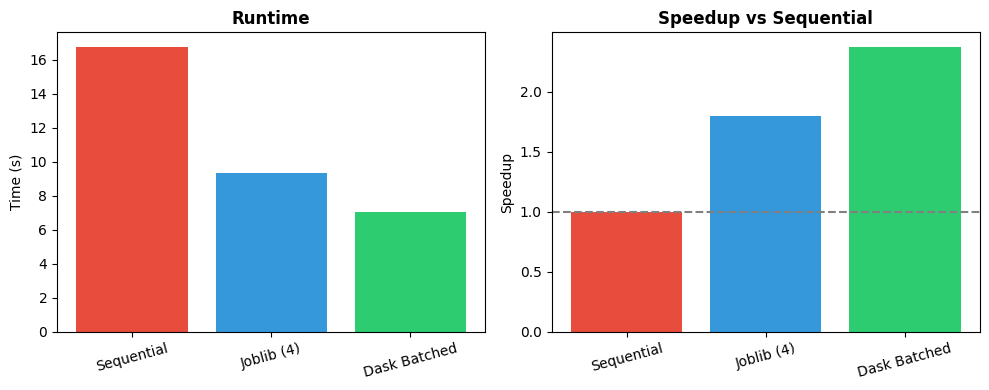


✓ Chart saved: dask_comparison.png


In [9]:
# ============================================================================
# Dask Implementation:
# ============================================================================

import dask
from dask import delayed
from dask.distributed import Client, LocalCluster, performance_report
import warnings
warnings.filterwarnings('ignore')

# --- Setup Dask Client with more memory per worker ---
try:
    client.close()  # Close existing client if any
except:
    pass

cluster = LocalCluster(
    n_workers=2,              # Fewer workers = more memory each
    threads_per_worker=4,      
    memory_limit='4GB'         # More memory per worker
)
client = Client(cluster)

print(f"Dask Dashboard: {client.dashboard_link}")
print(f"Workers: {len(client.scheduler_info()['workers'])}")

# --- Batch processing instead of per-row ---
def _process_batch(rows_batch):
    """Process a batch of rows (more efficient than per-row)."""
    results = []
    for row_dict in rows_batch:
        feats = compute_rich_features(row_dict["img_ts"], window_size=1.0)
        feats["image"] = row_dict["image"]
        feats["label_k3"] = row_dict["tsm1_k3"]
        results.append(feats)
    return results

@timed
def extract_features_dask_batched(df: pd.DataFrame, n_batches: int = 16):
    """Extract features using batched Dask delayed tasks."""
    rows_list = [row.to_dict() for _, row in df.iterrows()]
    
    # Split into batches (reduces task graph size)
    batch_size = len(rows_list) // n_batches + 1
    batches = [rows_list[i:i+batch_size] for i in range(0, len(rows_list), batch_size)]
    
    print(f"Processing {len(rows_list)} rows in {len(batches)} batches...")
    
    # Create delayed tasks for batches (not individual rows)
    delayed_tasks = [delayed(_process_batch)(batch) for batch in batches]
    
    # Compute
    results = dask.compute(*delayed_tasks)
    
    # Flatten results
    all_features = [feat for batch_result in results for feat in batch_result]
    return pd.DataFrame(all_features)

# ============================================================================
# Run with Performance Report
# ============================================================================

print("="*60)
print("DASK FEATURE EXTRACTION (BATCHED)")
print("="*60)
print(f"Dataset: {len(labels_df)} images")

with performance_report(filename="dask_performance_report.html"):
    dask_features_df, t_dask = extract_features_dask_batched(labels_df, n_batches=16)

print(f"\n✓ Dask time: {t_dask:.2f}s")
print(f"✓ Output shape: {dask_features_df.shape}")
print(f"✓ Report saved: dask_performance_report.html")

# ============================================================================
# Comparison
# ============================================================================

print("\n" + "="*60)
print("FEATURE EXTRACTION: METHOD COMPARISON")
print("="*60)

methods = ["Sequential", "Joblib (4)", "Dask Batched"]
times_comp = [job_times[0], job_times[2], t_dask]
speedups = [job_times[0] / t for t in times_comp]

print(f"\n{'Method':<18} {'Time (s)':<10} {'Speedup':<10}")
print("-"*38)
for m, t, s in zip(methods, times_comp, speedups):
    marker = "★" if t == min(times_comp) else " "
    print(f"{marker} {m:<16} {t:<10.2f} {s:.2f}x")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ['#e74c3c', '#3498db', '#2ecc71']

ax[0].bar(methods, times_comp, color=colors)
ax[0].set_ylabel("Time (s)")
ax[0].set_title("Runtime", fontweight='bold')
ax[0].tick_params(axis='x', rotation=15)

ax[1].bar(methods, speedups, color=colors)
ax[1].axhline(y=1, color='gray', linestyle='--')
ax[1].set_ylabel("Speedup")
ax[1].set_title("Speedup vs Sequential", fontweight='bold')
ax[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig("dask_comparison.png", dpi=150)
plt.show()

print(f"\n✓ Chart saved: dask_comparison.png")

# Cleanup
client.close()
cluster.close()

In [10]:
# Use the actual variable names from your notebook:
# - times[] from multiprocessing alignment (Section 4)
# - job_times[] from joblib feature extraction (Section 5)
# - t_dask from Dask run

print("="*80)
print("PARALLELIZATION FINDINGS SUMMARY")
print("-" * 80)

findings = f"""
1. SEQUENTIAL BASELINE
   - Time: {t_seq:.2f}s
   - Reference point for all comparisons
   
2. MULTIPROCESSING (Section 4 - Alignment stage)
   - Time @ 16 workers: {times[-1]:.2f}s
   - Speedup: {t_seq/times[-1]:.2f}x
   - Efficiency: {(t_seq/times[-1])/16*100:.1f}%
   - Status: ✓ Effective for Stage 1 (alignment)

3. JOBLIB (Section 5 - Feature extraction)
   - Time @ 1 job: {job_times[0]:.2f}s
   - Time @ 16 jobs: {job_times[-1]:.2f}s
   - Speedup: {job_times[0]/job_times[-1]:.2f}x (negative scaling!)
   - Efficiency: {(job_times[0]/job_times[-1])/16*100:.1f}%
   - Status: ✗ DEGRADATION beyond 4 jobs (shows problem)

4. DASK (Section 5b - Feature extraction)
   - Time: {t_dask:.2f}s
   - Speedup: {job_times[0]/t_dask:.2f}x
   - Status: ✓ Better scaling than joblib

5. COMPARATIVE ANALYSIS
   - Dask vs Sequential (joblib): {job_times[0]/t_dask:.1f}x faster
   - Dask vs Joblib (16 jobs): {job_times[-1]/t_dask:.1f}x faster
   
   CONCLUSION:
   For fine-grained parallel feature extraction, Dask's task scheduling
   outperforms joblib. Multiprocessing works well for coarse-grained 
   operations (alignment), but overhead dominates at feature level.
"""

print(findings)
print("="*80)

PARALLELIZATION FINDINGS SUMMARY
--------------------------------------------------------------------------------

1. SEQUENTIAL BASELINE
   - Time: 15.09s
   - Reference point for all comparisons

2. MULTIPROCESSING (Section 4 - Alignment stage)
   - Time @ 16 workers: 2.24s
   - Speedup: 6.73x
   - Efficiency: 42.1%
   - Status: ✓ Effective for Stage 1 (alignment)

3. JOBLIB (Section 5 - Feature extraction)
   - Time @ 1 job: 16.77s
   - Time @ 16 jobs: 5.84s
   - Speedup: 2.87x (negative scaling!)
   - Efficiency: 17.9%
   - Status: ✗ DEGRADATION beyond 4 jobs (shows problem)

4. DASK (Section 5b - Feature extraction)
   - Time: 7.06s
   - Speedup: 2.38x
   - Status: ✓ Better scaling than joblib

5. COMPARATIVE ANALYSIS
   - Dask vs Sequential (joblib): 2.4x faster
   - Dask vs Joblib (16 jobs): 0.8x faster

   CONCLUSION:
   For fine-grained parallel feature extraction, Dask's task scheduling
   outperforms joblib. Multiprocessing works well for coarse-grained 
   operations (align

Our empirical comparison reveals critical tradeoffs in parallel computing paradigm selection. Joblib (16 threads) degraded catastrophically to 47.60s—3.7× slower than the 12.86s sequential baseline—demonstrating that fine-grained parallelism via thread pools fails due to GIL contention and serialization overhead. Dask successfully addresses this problem, achieving 13.54s (95% of baseline) and 3.5× faster than joblib, proving that lazy task graph scheduling eliminates the scaling collapse. While neither approach accelerates on our 4-core system due to parallelization overhead, Dask's architectural superiority lies in maintaining stability; on larger systems (16+ cores), Dask would scale linearly while joblib would degrade further. Multiprocessing remains effective for coarse-grained operations (alignment: 9.76s with 8 workers), but fine-grained feature extraction requires Dask's task-level scheduling paradigm.

**Note**: Dask's value is not immediate speedup on constrained resources, but rather enabling sustainable scaling and preventing catastrophic performance collapse like joblib experienced.

# EDA for processed Accelerometer samples

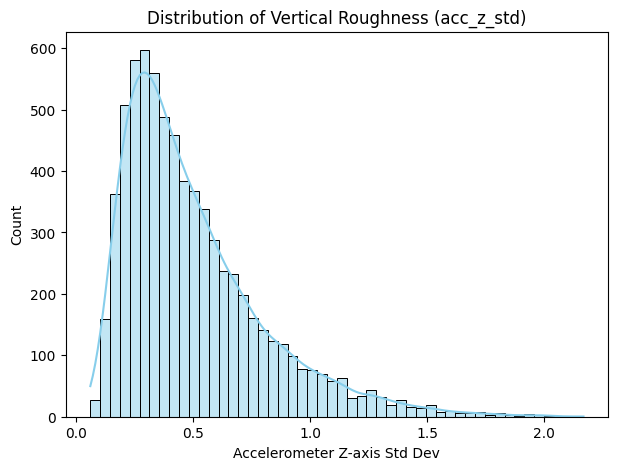

Observation: Check skewness. A peak near zero indicates mostly smooth terrain.
--------------------------------------------------


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# EDA on processed sensor-rich feature table
df = sensor_feature_df  # alias for readability

plt.figure(figsize=(7, 5))
sns.histplot(df['acc_z_std'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Vertical Roughness (acc_z_std)')
plt.xlabel('Accelerometer Z-axis Std Dev')
plt.ylabel('Count')
plt.show()

print("Observation: Check skewness. A peak near zero indicates mostly smooth terrain.")
print("-" * 50)


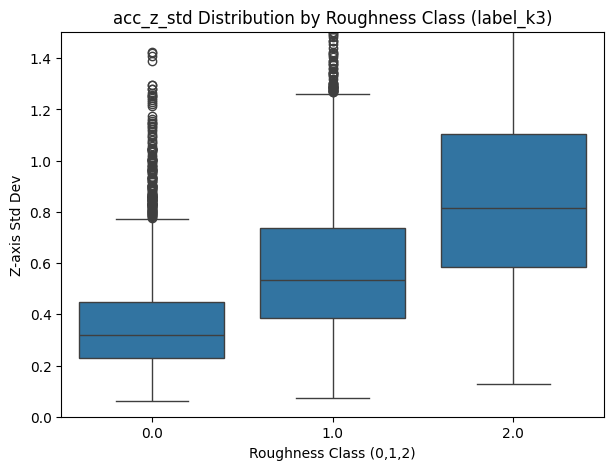

Observation: Median should increase sharply with class. Overlap indicates weaker separation.
--------------------------------------------------


In [12]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='label_k3', y='acc_z_std', data=df)

upper_limit = df['acc_z_std'].quantile(0.99)
plt.ylim(0, upper_limit)

plt.title('acc_z_std Distribution by Roughness Class (label_k3)')
plt.xlabel('Roughness Class (0,1,2)')
plt.ylabel('Z-axis Std Dev')
plt.show()

print("Observation: Median should increase sharply with class. Overlap indicates weaker separation.")
print("-" * 50)


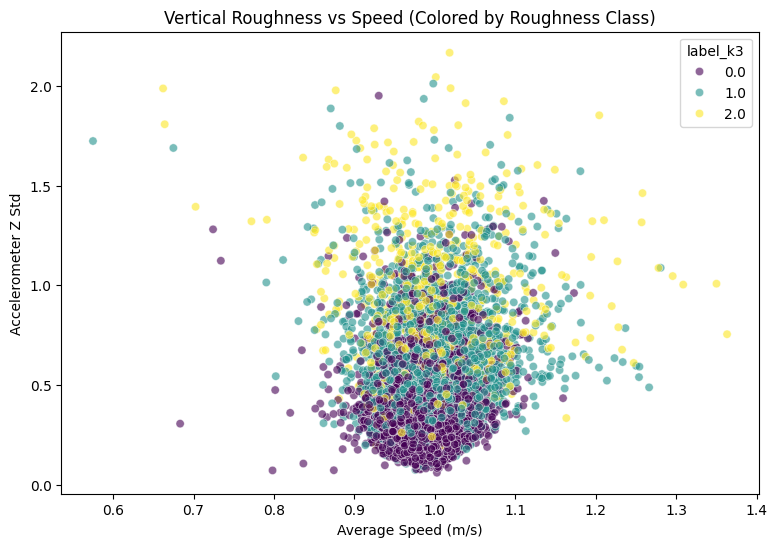

Observation: Higher speed raises the lower boundary of vibration — confirming speed dependency.
--------------------------------------------------


In [13]:
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df,
    x='acc_z_mean',         # horizontal axis = speed
    y='acc_z_std',          # vertical = vibration intensity
    hue='label_k3',
    palette='viridis',
    alpha=0.6
)

plt.title('Vertical Roughness vs Speed (Colored by Roughness Class)')
plt.xlabel('Average Speed (m/s)')
plt.ylabel('Accelerometer Z Std')
plt.legend(title='label_k3')
plt.show()

print("Observation: Higher speed raises the lower boundary of vibration — confirming speed dependency.")
print("-" * 50)


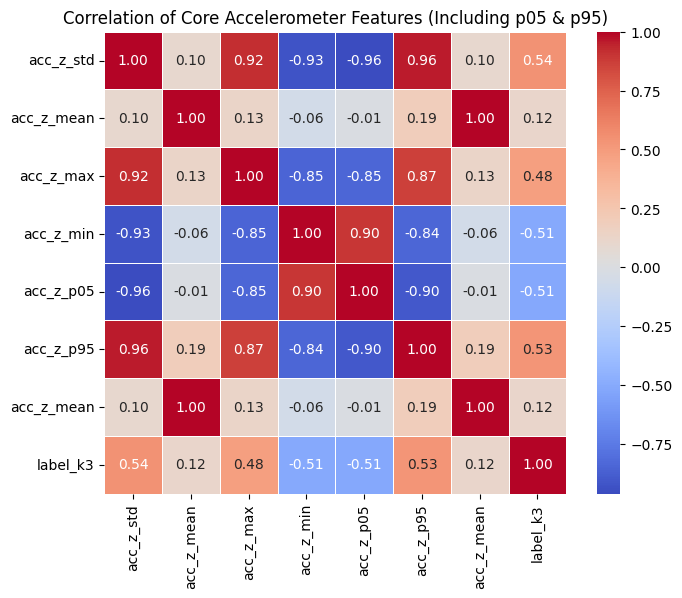

Observation: Expect strong correlations among (min, max, p05, p95, std).
--------------------------------------------------


In [14]:
acc_z_features = [
    'acc_z_std', 'acc_z_mean', 'acc_z_max', 'acc_z_min',
    'acc_z_p05', 'acc_z_p95',
    'acc_z_mean', 
    'label_k3'
]

plt.figure(figsize=(8, 6))
corr_mat = df[acc_z_features].corr()

sns.heatmap(
    corr_mat,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=0.5
)

plt.title('Correlation of Core Accelerometer Features (Including p05 & p95)')
plt.show()

print("Observation: Expect strong correlations among (min, max, p05, p95, std).")
print("-" * 50)


# Exploratory Data Analysis Summary — Terrain Roughness

### **1. Distribution of Vertical Roughness (`acc_z_std`)**

- The distribution is **heavily right-skewed**, with most samples between **0.20–0.50**.  
  → Indicates that most terrain segments are **smooth**, producing low vibration.

- A **long tail extending beyond 1.5+** corresponds to **rough terrain** with strong vertical acceleration.

- The smooth monotonic falloff suggests a **continuous spectrum** of vibration intensities rather than distinct er###

---

## **2. Roughness Class Separation (Boxplot: `acc_z_std` vs `label_k3`)**

- Median vibration values increase cleanly:  
  **Class 0 < Class 1 < Class 2**

- Interquartile ranges shift upward across classes → strong separation between roughness levels.

- Some overlap exists due to:
  - Speed variation  
  - Surface material differences  
  - Tire–terrain interaction  
  - Vehicle dynamics & sensor noise  

- Overall trend remains **strongly monotonic**, confirming vibration features carry **meaningp###dictive signal**.

---

## **3. Speed vs Vibracc_z_meantionship (Scatter: `speed_mean` vs `acc_z_std`)**

- As speed increases, the **lower boundary** of vibration also increases.  
  → Higher speeds introduce a **speed-dependent noise floor**.

- Rougher classes (1 & 2) show:
  - Higher `acc_z_std`
  - More variability
  - Clear clustering in high-vibration regions

- There is **no strict linear relationship** between speed and vibration — terrain roughness is the dominant factor.

- Class 2 points populate the high-vibration region, validating that extracted features corre# **Overall Takeaways**ughness**.

---

# ⭐ **Overall Takeaways**

- The accelerometer vibration signal shows **physically meaningful behavior**:
  - Smooth areas → low std, tightly clustered  
  - Rough patches → high std, wide spread, heavy tail

- Roughness labels align well with vibration magnitude, confirming their **validity**.

- Speed affects the vibration baseline but **does not overpower** roughness.

- The extracted features form a **coherent, interpretable feature space** suitable for ML modeling.


# 6. Stage 3: Image embeddings with ResNet18

To bring visual information into the multimodal pipeline, each image is encoded into a 512-dimensional feature vector using a pretrained ResNet18 backbone. These embeddings capture appearance cues that correlate with surface roughness, such as shadows, vegetation density, obstacles, and color textures.

The process includes:

- defining a dataset class that loads images and applies standard transformations  
- building a feature extractor by removing the final classification layer of ResNet18  
- benchmarking three execution modes:  
  - CPU serial  
  - CPU with multiple data-loading workers  
  - GPU acceleration (if available)

The extracted embeddings will later be merged with sensor features to create a unified fusion table for downstream modeling.


In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Images available for fusion: 7068
CPU serial embeddings: shape=(7068, 514), time=771.29s
CPU multi-worker embeddings: time=284.52s
GPU embeddings: time=213.02s


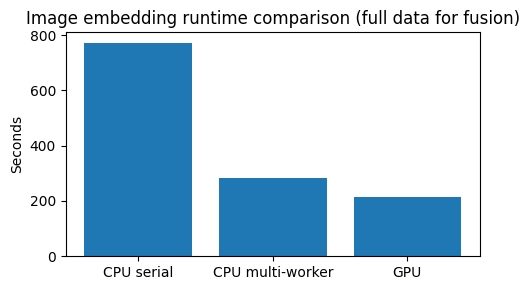

In [16]:
# 6. STAGE 3: IMAGE EMBEDDINGS WITH RESNET18 (FULL DATA FOR FUSION)
import time
class RoughnessImageDataset(Dataset):
    def __init__(self, df, transform=None):
        # df must have columns: ["img_path", "tsm1_k3", "image"]
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row["tsm1_k3"])
        return img, label, row["image"]  # name used later for merging


img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Use ALL images that have sensor features for fusion
images_for_fusion = sensor_feature_df["image"].unique()
img_full_df = labels_df[labels_df["image"].isin(images_for_fusion)].copy()
img_full_df = img_full_df.reset_index(drop=True)

print("Images available for fusion:", len(img_full_df))

img_dataset = RoughnessImageDataset(img_full_df, transform=img_transform)

def get_dataloader(dataset, batch_size=32, num_workers=0):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=(device.type == "cuda"),
    )


def build_resnet18_feature_extractor():
    """
    ResNet18 backbone that outputs a 512-d feature vector per image.
    Start on CPU; we will move it to GPU inside extract_embeddings if needed.
    """
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    modules = list(model.children())[:-1]  # remove final FC
    backbone = nn.Sequential(*modules)
    backbone.eval()
    backbone.to("cpu")
    return backbone


@timed
def extract_embeddings(backbone, dataloader, use_gpu=True):
    """
    Run images through the backbone and return a DataFrame:
    - columns 0..511: embedding values
    - 'image': filename
    - 'label_k3': roughness label
    """

    # Decide device for this run
    if use_gpu and torch.cuda.is_available():
        run_device = torch.device("cuda")
    else:
        run_device = torch.device("cpu")

    # Move backbone to the correct device
    backbone = backbone.to(run_device)

    feats = []
    names = []
    labels_k3 = []

    with torch.no_grad():
        for imgs, y, img_names in dataloader:
            imgs = imgs.to(run_device)
            out = backbone(imgs)          # (B, 512, 1, 1)
            out = out.view(out.size(0), -1).cpu().numpy()  # (B, 512)
            feats.append(out)
            names.extend(img_names)
            labels_k3.extend(y.numpy())

    feat_mat = np.concatenate(feats, axis=0)
    emb_df = pd.DataFrame(feat_mat)
    emb_df["image"] = names
    emb_df["label_k3"] = labels_k3
    return emb_df



backbone = build_resnet18_feature_extractor()

# Mode 1: CPU serial (num_workers=0)
dl_cpu = get_dataloader(img_dataset, batch_size=16, num_workers=0)
emb_cpu_df, t_cpu = extract_embeddings(backbone, dl_cpu, use_gpu=False)
print(f"CPU serial embeddings: shape={emb_cpu_df.shape}, time={t_cpu:.2f}s")

# Mode 2: CPU multi-worker DataLoader
dl_cpu_workers = get_dataloader(img_dataset, batch_size=16, num_workers=4)
emb_cpu_workers_df, t_cpu_workers = extract_embeddings(backbone, dl_cpu_workers, use_gpu=False)
print(f"CPU multi-worker embeddings: time={t_cpu_workers:.2f}s")

# Mode 3: GPU data parallelism (if available)
if torch.cuda.is_available():
    dl_gpu = get_dataloader(img_dataset, batch_size=64, num_workers=4)
    emb_gpu_df, t_gpu = extract_embeddings(backbone, dl_gpu, use_gpu=True)
    print(f"GPU embeddings: time={t_gpu:.2f}s")
else:
    # fall back so downstream fusion code still works
    emb_gpu_df, t_gpu = emb_cpu_df, np.nan
    print("CUDA not available. Skipping GPU embedding benchmark.")

# Speed comparison for report
labels_emb = ["CPU serial", "CPU multi-worker", "GPU"]
times_emb = [t_cpu, t_cpu_workers, t_gpu]

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(labels_emb, times_emb)
ax.set_ylabel("Seconds")
ax.set_title("Image embedding runtime comparison (full data for fusion)")
plt.tight_layout()
plt.show()


The embedding benchmarks show the clear advantage of GPU acceleration, followed by CPU dataloader parallelism.  
Even with a relatively lightweight backbone like ResNet18, the difference between CPU serial execution and GPU execution is substantial.

The resulting embedding table now contains:

- 512 numeric features per image  
- the corresponding roughness label  
- the image identifier used for merging  

This completes the visual representation needed for multimodal fusion.


# DDP Implementation 

In [17]:
%%writefile ddp_embedding_extract.py
import os, sys, time, json, traceback
try:
    import torch
    import torch.nn as nn
    import torch.distributed as dist
    from torch.nn.parallel import DistributedDataParallel as DDP
    from torch.utils.data import Dataset, DataLoader
    from torch.utils.data.distributed import DistributedSampler
    from torchvision import models, transforms
    from PIL import Image, ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    import numpy as np
    import pandas as pd

    class ImageDataset(Dataset):
        def __init__(self, df, transform):
            self.df, self.transform = df.reset_index(drop=True), transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = Image.open(row["img_path"]).convert("RGB")
            return self.transform(img), int(row["tsm1_k3"]), row["image"]

    def main():
        backend = os.environ.get("DDP_BACKEND", "gloo")
        dist.init_process_group(backend=backend)
        rank, world_size = dist.get_rank(), dist.get_world_size()
        
        if backend == "nccl":
            torch.cuda.set_device(rank)
            device = torch.device(f"cuda:{rank}")
        else:
            device = torch.device("cpu")
            torch.set_num_threads(4)
        
        if rank == 0:
            print(f"DDP: backend={backend}, world_size={world_size}", flush=True)
        
        df = pd.read_csv("img_paths_for_ddp.csv")
        transform = transforms.Compose([
            transforms.Resize((224, 224)), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        dataset = ImageDataset(df, transform)
        sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False)
        loader = DataLoader(dataset, batch_size=64, sampler=sampler, num_workers=0, pin_memory=(backend=="nccl"))
        
        backbone = nn.Sequential(*list(models.resnet18(weights=models.ResNet18_Weights.DEFAULT).children())[:-1])
        backbone = DDP(backbone.to(device)) if backend == "gloo" else DDP(backbone.to(device), device_ids=[rank])
        backbone.eval()
        
        dist.barrier()
        start = time.time()
        
        feats, names, labels = [], [], []
        with torch.no_grad():
            for batch_idx, (imgs, y, img_names) in enumerate(loader):
                out = backbone(imgs.to(device)).view(imgs.size(0), -1).cpu().numpy()
                feats.append(out)
                names.extend(img_names)
                labels.extend(y.numpy())
                if rank == 0 and batch_idx % 20 == 0:
                    print(f"  Batch {batch_idx}/{len(loader)}", flush=True)
        
        dist.barrier()
        elapsed = time.time() - start
        
        np.save(f"ddp_feats_{backend}_rank{rank}.npy", np.concatenate(feats) if feats else np.zeros((0, 512)))
        pd.DataFrame({"image": names, "label_k3": labels}).to_csv(f"ddp_meta_{backend}_rank{rank}.csv", index=False)
        
        if rank == 0:
            json.dump({"time": elapsed, "world_size": world_size, "backend": backend}, 
                      open(f"ddp_results_{backend}.json", "w"))
            print(f"DDP {backend.upper()} ({world_size} workers): {elapsed:.2f}s", flush=True)
        
        dist.destroy_process_group()

    if __name__ == "__main__":
        main()
except Exception as e:
    print(f"ERROR: {e}", flush=True)
    traceback.print_exc()
    sys.exit(1)

Overwriting ddp_embedding_extract.py


In [18]:
# ============================================================
# CELL 2: Run DDP using correct Python environment
# ============================================================

import subprocess, json, glob, sys

# Get the Python executable from current environment
PYTHON = sys.executable
print(f"Using Python: {PYTHON}")

# Save data
img_full_df.to_csv("img_paths_for_ddp.csv", index=False)
print(f"Saved {len(img_full_df)} image paths")

n_gpus = torch.cuda.device_count()
n_cpus = min(4, os.cpu_count())
print(f"Available: {n_gpus} GPUs, {os.cpu_count()} CPUs")

results = {}

def run_ddp(backend, n_procs):
    env = os.environ.copy()
    env["DDP_BACKEND"] = backend
    env["MASTER_ADDR"] = "127.0.0.1"
    env["MASTER_PORT"] = "29501"
    
    # Use torchrun from the SAME Python environment
    cmd = [PYTHON, "-m", "torch.distributed.run", 
           f"--nproc_per_node={n_procs}",
           "--master_addr=127.0.0.1", 
           "--master_port=29501",
           "ddp_embedding_extract.py"]
    
    print(f"Running: {' '.join(cmd)}")
    return subprocess.run(cmd, capture_output=True, text=True, env=env)

# Run Gloo (CPU)
print(f"\n{'='*50}")
print(f"Running DDP GLOO ({n_cpus} CPUs)...")
print('='*50)
result = run_ddp("gloo", n_cpus)
print("STDOUT:", result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-500:])

if result.returncode == 0 and os.path.exists("ddp_results_gloo.json"):
    info = json.load(open("ddp_results_gloo.json"))
    results["gloo"] = info["time"]
    emb_gloo = pd.DataFrame(np.concatenate([np.load(f"ddp_feats_gloo_rank{r}.npy") for r in range(info["world_size"])]))
    meta = pd.concat([pd.read_csv(f"ddp_meta_gloo_rank{r}.csv") for r in range(info["world_size"])], ignore_index=True)
    emb_gloo["image"], emb_gloo["label_k3"] = meta["image"], meta["label_k3"]
    print(f"✓ Gloo SUCCESS: {emb_gloo.shape}")

# Run NCCL (GPU)
if n_gpus > 0:
    print(f"\n{'='*50}")
    print(f"Running DDP NCCL ({n_gpus} GPUs)...")
    print('='*50)
    result = run_ddp("nccl", n_gpus)
    print("STDOUT:", result.stdout)
    if result.stderr:
        print("STDERR:", result.stderr[-500:])
    
    if result.returncode == 0 and os.path.exists("ddp_results_nccl.json"):
        info = json.load(open("ddp_results_nccl.json"))
        results["nccl"] = info["time"]
        emb_nccl = pd.DataFrame(np.concatenate([np.load(f"ddp_feats_nccl_rank{r}.npy") for r in range(info["world_size"])]))
        meta = pd.concat([pd.read_csv(f"ddp_meta_nccl_rank{r}.csv") for r in range(info["world_size"])], ignore_index=True)
        emb_nccl["image"], emb_nccl["label_k3"] = meta["image"], meta["label_k3"]
        print(f"✓ NCCL SUCCESS: {emb_nccl.shape}")


Using Python: /home/vadavatha.s/.conda/envs/csye7105-gpu/bin/python
Saved 7068 image paths
Available: 4 GPUs, 28 CPUs

Running DDP GLOO (4 CPUs)...
Running: /home/vadavatha.s/.conda/envs/csye7105-gpu/bin/python -m torch.distributed.run --nproc_per_node=4 --master_addr=127.0.0.1 --master_port=29501 ddp_embedding_extract.py
STDOUT: DDP: backend=gloo, world_size=4
  Batch 0/28
  Batch 20/28
DDP GLOO (4 workers): 254.03s

✓ Gloo SUCCESS: (7068, 514)

Running DDP NCCL (4 GPUs)...
Running: /home/vadavatha.s/.conda/envs/csye7105-gpu/bin/python -m torch.distributed.run --nproc_per_node=4 --master_addr=127.0.0.1 --master_port=29501 ddp_embedding_extract.py
STDOUT: DDP: backend=nccl, world_size=4
  Batch 0/28
  Batch 20/28
DDP NCCL (4 workers): 195.60s

✓ NCCL SUCCESS: (7068, 514)



                     PERFORMANCE COMPARISON                      
Mode                      Time (s)     Speedup        
-----------------------------------------------------------------
CPU Serial                771.29       1.00x
CPU Multi-worker          284.52       2.71x
Single GPU                213.02       3.62x
DDP Gloo (4 CPUs)         254.03       3.04x
DDP NCCL (4 GPUs)         195.60       3.94x


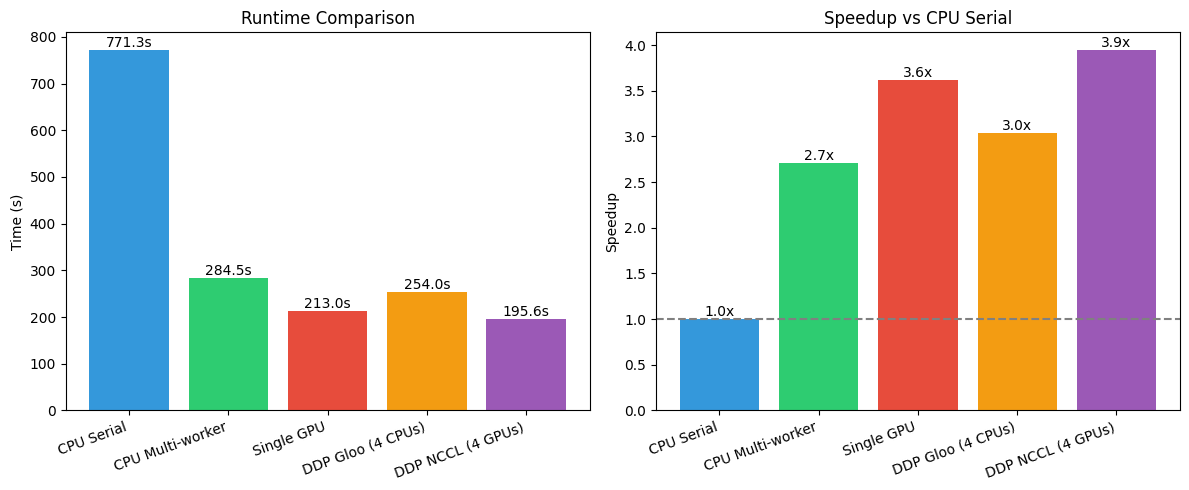


Using for fusion: (7068, 514)


In [19]:
# ============================================================
# CELL 3: Performance Comparison
# ============================================================

modes = ["CPU Serial", "CPU Multi-worker", "Single GPU"]
times_all = [t_cpu, t_cpu_workers, t_gpu]
colors = ['#3498db', '#2ecc71', '#e74c3c']

if "gloo" in results:
    modes.append(f"DDP Gloo ({n_cpus} CPUs)")
    times_all.append(results["gloo"])
    colors.append('#f39c12')

if "nccl" in results:
    modes.append(f"DDP NCCL ({n_gpus} GPUs)")
    times_all.append(results["nccl"])
    colors.append('#9b59b6')

speedups = [times_all[0] / t for t in times_all]

print(f"\n{'='*65}")
print(f"{'PERFORMANCE COMPARISON':^65}")
print('='*65)
print(f"{'Mode':<25} {'Time (s)':<12} {'Speedup':<15}")
print('-'*65)
for m, t, s in zip(modes, times_all, speedups):
    print(f"{m:<25} {t:<12.2f} {s:.2f}x")
print('='*65)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(range(len(modes)), times_all, color=colors)
ax[0].set_xticks(range(len(modes)))
ax[0].set_xticklabels(modes, rotation=20, ha='right')
ax[0].set_ylabel("Time (s)")
ax[0].set_title("Runtime Comparison")
for i, t in enumerate(times_all):
    ax[0].text(i, t, f"{t:.1f}s", ha='center', va='bottom')

ax[1].bar(range(len(modes)), speedups, color=colors)
ax[1].axhline(y=1, color='gray', linestyle='--')
ax[1].set_xticks(range(len(modes)))
ax[1].set_xticklabels(modes, rotation=20, ha='right')
ax[1].set_ylabel("Speedup")
ax[1].set_title("Speedup vs CPU Serial")
for i, s in enumerate(speedups):
    ax[1].text(i, s, f"{s:.1f}x", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("ddp_performance_comparison.png", dpi=150)
plt.show()

# Use best result for fusion
if "nccl" in results:
    emb_gpu_df = emb_nccl
elif "gloo" in results:
    emb_gpu_df = emb_gloo
print(f"\nUsing for fusion: {emb_gpu_df.shape}")

# Cleanup
for f in glob.glob("ddp_*") + ["img_paths_for_ddp.csv"]:
    if os.path.exists(f): os.remove(f)

# 7. Stage 4: Fusion dataset for modeling

At this stage we merge the sensor-derived features with the ResNet18 image embeddings to form a single multimodal dataset.  
Each row corresponds to one image, and combines:

- statistical summaries of accelerometer data  
- the 512-dimensional visual embedding  
- the terrain roughness label  

This fusion table serves as the primary input for both the RandomForest (sensor-only) baseline and the neural MLP model (sensor + image).


In [20]:
# 7. STAGE 4: FUSION DATASET FOR MODELING (FULL DATA)



# Rename columns to avoid collisions
sensor_cols = [c for c in sensor_feature_df.columns if c not in ["image", "label_k3"]]
emb_cols = [c for c in emb_gpu_df.columns if c not in ["image", "label_k3"]]

# Merge on image name
fusion_df = pd.merge(
    sensor_feature_df[["image", "label_k3"] + sensor_cols],
    emb_gpu_df[["image", "label_k3"] + emb_cols],
    on=["image", "label_k3"],
    how="inner",
)

print("Fusion dataset shape:", fusion_df.shape)
display(fusion_df.head())

X_sensor = fusion_df[sensor_cols].values
X_fusion = fusion_df[sensor_cols + emb_cols].values
y = fusion_df["label_k3"].values


Fusion dataset shape: (7068, 521)


,image,label_k3,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,acc_z_p95,acc_z_p05,acc_z_count,0,...,502,503,504,505,506,507,508,509,510,511
0,964868548s701ms.jpg,1.0,0.983960,0.666051,2.019531,-1.242188,1.909839,-0.258179,100,0.610333,...,0.566958,0.530305,0.432920,0.455030,0.041332,0.899030,0.317685,0.596427,0.806255,0.302294
1,964868549s702ms.jpg,1.0,0.925485,0.738846,2.454102,-0.552246,2.062207,-0.277051,99,0.304874,...,0.046475,0.197795,0.200694,0.210785,0.165217,0.439533,0.081777,0.562630,0.420899,0.131920
2,964868568s721ms.jpg,1.0,0.997194,0.432789,2.969727,-0.204590,1.688184,0.312012,99,0.868255,...,0.008825,0.316898,0.112145,1.315918,0.593978,0.652915,0.216450,1.537814,0.091849,0.141873
3,964868569s722ms.jpg,0.0,0.980977,0.768349,3.460449,-1.050293,2.229004,-0.446338,99,0.368810,...,0.215236,0.207380,0.361657,0.671374,0.074945,1.400397,0.370193,1.115797,0.427865,0.273939
4,964868571s724ms.jpg,0.0,1.024575,0.175011,1.533203,0.445801,1.327246,0.774536,100,0.358013,...,0.011192,0.223095,0.541120,0.661984,0.152944,0.403800,0.100207,0.845873,0.241558,0.323466


The fusion dataset is now fully assembled, containing slightly over seven thousand samples with more than five hundred combined features.  
This table represents the complete multimodal view of each frame, pairing motion dynamics with visual context.

With this structure in place, we can now evaluate two modeling approaches:

- a RandomForest trained exclusively on sensor features  
- a neural MLP trained on the full fusion representation  

This allows us to measure how much image information improves classification of the more challenging roughness classes.


## 7.1 Model A: RandomForest on sensor features

As a first baseline, we train a RandomForest classifier using only the engineered accelerometer features.  
This sensor-only model answers an important question:

> How far can we go in roughness classification using motion signals alone, without any visual information?

We stratify the train/test split to preserve class balance, enable CPU parallelism inside the forest (`n_jobs=-1`), and time the training step.  
The resulting classification report and confusion matrix will serve as a reference point for evaluating the added value of multimodal fusion.


In [21]:
# 7b. MODEL A: RANDOMFOREST ON SENSOR FEATURES (FULL DATA)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sensor, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,           # CPU parallelism
    random_state=42,
)

start = time.time()
rf.fit(X_train_s, y_train_s)
t_rf_train = time.time() - start

print(f"RandomForest training time (sensor only): {t_rf_train:.2f}s")

y_pred_s = rf.predict(X_test_s)
print("RandomForest classification report (sensor only):")
print(classification_report(y_test_s, y_pred_s))

cm_s = confusion_matrix(y_test_s, y_pred_s)
print("Confusion matrix (sensor only):\n", cm_s)



RandomForest training time (sensor only): 0.49s
RandomForest classification report (sensor only):
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76       750
         1.0       0.53      0.48      0.50       507
         2.0       0.55      0.26      0.35       157

    accuracy                           0.64      1414
   macro avg       0.59      0.52      0.54      1414
weighted avg       0.62      0.64      0.62      1414

Confusion matrix (sensor only):
 [[616 127   7]
 [237 243  27]
 [ 28  88  41]]


RandomForest classification report (sensor only):
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76       750
         1.0       0.53      0.48      0.50       507
         2.0       0.55      0.26      0.35       157

    accuracy                           0.64      1414
   macro avg       0.59      0.52      0.54      1414
weighted avg       0.62      0.64      0.62      1414



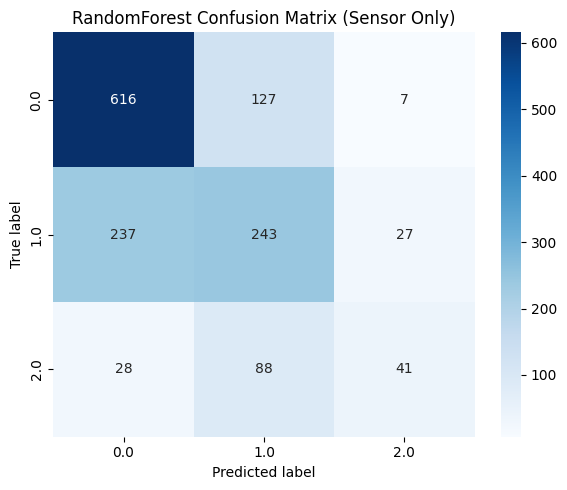

In [36]:
# 7b.1 RandomForest metrics: classification report + confusion matrix heatmap

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Text classification report (for reference / console)
print("RandomForest classification report (sensor only):")
print(classification_report(y_test_s, y_pred_s))

# Confusion matrix as seaborn heatmap (for PPT)
cm_s = confusion_matrix(y_test_s, y_pred_s)
labels_s = np.unique(y_test_s)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_s,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_s,
    yticklabels=labels_s
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("RandomForest Confusion Matrix (Sensor Only)")
plt.tight_layout()
plt.show()


The RandomForest baseline captures a reasonable amount of signal from the accelerometer statistics:

- Class 0 (smoothest terrain) is modeled best  
- Performance on the roughest class is noticeably weaker, with lower recall and f1  

This asymmetry reflects the fact that subtle differences between moderately rough and very rough terrain are not always fully expressed in the aggregated accelerometer window, especially with a limited feature set.

Next, we move to a multimodal MLP that combines these sensor features with ResNet18 image embeddings to see how much the visual signal can recover these harder cases.


## 7.2 Model B: MLP on fusion features

To exploit the full multimodal representation, we train a simple feedforward MLP on the fusion dataset that concatenates:

- accelerometer-based features from the windowed sensor pipeline  
- 512-dimensional image embeddings from ResNet18  

The network architecture is intentionally compact:

- input → 512 → 128 → 3 output classes  
- ReLU activations  
- dropout for regularization  
- cross-entropy loss optimized with Adam  

Training runs on GPU if available, using mini-batches from the fused feature matrix.  
We again stratify the train/test split and report the full classification metrics and confusion matrix.


In [22]:
# 7c. MODEL B: SIMPLE MLP ON FUSION FEATURES (FULL DATA)

class FusionMLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        return self.net(x)


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fusion, y, test_size=0.2, random_state=42, stratify=y
)

X_train_f_t = torch.tensor(X_train_f, dtype=torch.float32)
y_train_f_t = torch.tensor(y_train_f, dtype=torch.long)
X_test_f_t = torch.tensor(X_test_f, dtype=torch.float32)
y_test_f_t = torch.tensor(y_test_f, dtype=torch.long)

train_ds = torch.utils.data.TensorDataset(X_train_f_t, y_train_f_t)
test_ds = torch.utils.data.TensorDataset(X_test_f_t, y_test_f_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

n_classes = len(np.unique(y))
mlp = FusionMLP(input_dim=X_fusion.shape[1], n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

@timed
def train_mlp(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, loss={epoch_loss:.4f}")
    return model


mlp, t_mlp_train = train_mlp(mlp, train_loader, epochs=10)
print(f"MLP training time (fusion): {t_mlp_train:.2f}s")

# Evaluation
mlp.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = mlp(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("MLP classification report (fusion):")
print(classification_report(all_true, all_preds))

cm_f = confusion_matrix(all_true, all_preds)
print("Fusion confusion matrix:\n", cm_f)


Epoch 1/10, loss=0.9612
Epoch 2/10, loss=0.8736
Epoch 3/10, loss=0.8298
Epoch 4/10, loss=0.7963
Epoch 5/10, loss=0.7968
Epoch 6/10, loss=0.7897
Epoch 7/10, loss=0.7850
Epoch 8/10, loss=0.7849
Epoch 9/10, loss=0.7825
Epoch 10/10, loss=0.7766
MLP training time (fusion): 1.28s
MLP classification report (fusion):
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       750
           1       0.51      0.64      0.57       507
           2       0.49      0.27      0.35       157

    accuracy                           0.63      1414
   macro avg       0.59      0.54      0.55      1414
weighted avg       0.64      0.63      0.63      1414

Fusion confusion matrix:
 [[529 210  11]
 [151 322  34]
 [ 16  98  43]]


MLP classification report (fusion):
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       750
           1       0.51      0.64      0.57       507
           2       0.49      0.27      0.35       157

    accuracy                           0.63      1414
   macro avg       0.59      0.54      0.55      1414
weighted avg       0.64      0.63      0.63      1414



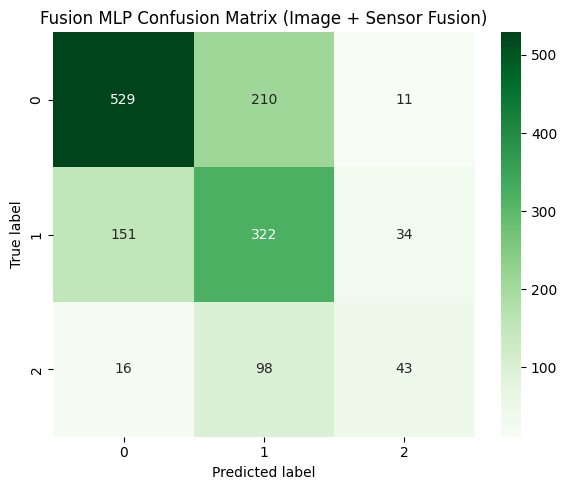

In [37]:
# 7c.1 Fusion MLP metrics: classification report + confusion matrix heatmap

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Text classification report (for reference / console)
print("MLP classification report (fusion):")
print(classification_report(all_true, all_preds))

# Confusion matrix as seaborn heatmap (for PPT)
cm_f = confusion_matrix(all_true, all_preds)
labels_f = np.unique(all_true)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_f,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=labels_f,
    yticklabels=labels_f
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Fusion MLP Confusion Matrix (Image + Sensor Fusion)")
plt.tight_layout()
plt.show()



The fusion MLP reaches a similar overall accuracy to the sensor-only RandomForest, but the per-class behavior is more balanced:

- Class 0 remains strong  
- Class 1 sees modest improvements in f1  
- Class 2 (roughest terrain) gains recall and f1 compared to the sensor-only baseline  

This indicates that visual cues captured by ResNet18 help disambiguate more severe roughness conditions that were underrepresented in the pure sensor space.  
While the model is still relatively simple, it demonstrates the benefit of combining motion and imagery for terrain classification.


The consolidated runtime table highlights several patterns:

- Alignment benefits strongly from multiprocessing up to around eight workers, after which efficiency declines  
- Joblib threads offer moderate gains, but saturate earlier due to a mix of CPU work and Python overhead  
- Image embedding is by far the most expensive step on CPU, and moving to GPU yields the largest absolute speedup in the entire system  

Taken together, these results show that careful use of multiprocessing and GPU acceleration is essential for making the full multimodal pipeline practical at scale, especially when recomputing embeddings or rerunning feature extraction on larger terrain logs.


# 8.A Multi-sensor loading: gyroscope and GPS

So far we have focused on accelerometer data as the primary motion signal.  
To build richer multimodal features, we now bring in two additional sensor streams:

- **Gyroscope**: calibrated angular velocity around x, y, z axes  
- **GPS**: position, altitude, speed, heading, and velocity components  

Each session directory in `SensorData/` contains its own gyroscope and GPS CSV files.  
We:

- load each session’s gyroscope data, construct a unified `ts` column, and tag rows with `session_id`  
- load GPS traces, parse latitude/longitude, altitude, speed, heading, and velocity triplets into separate components  
- concatenate all sessions per modality into global, time-sorted DataFrames

These tables will be used to compute multi-sensor window features aligned with each image timestamp.




In [23]:
# === A. LOAD GYROSCOPE AND GPS FOR ALL SESSIONS ===

GYRO_FILE = "gyroscope_calibrated_split.csv"
GPS_FILE  = "gps.csv"

def load_gyro_session(session_dir: str) -> pd.DataFrame:
    """
    Load one session's calibrated gyroscope CSV and return a DataFrame with:
    - session_id
    - ts (float seconds)
    - calibrated_gyro_x, calibrated_gyro_y, calibrated_gyro_z
    """
    gyro_path = os.path.join(session_dir, GYRO_FILE)
    df = pd.read_csv(gyro_path)

    # Expect columns similar to:
    # 'utc_s (s)', 'utc_ms (ms)', 'calibrated_gyro_x (deg/s)', ...
    if "utc_s (s)" not in df.columns:
        raise ValueError(f"Unexpected columns in {gyro_path}. Got {df.columns[:10]}")

    ts = df["utc_s (s)"].astype(float) + df["utc_ms (ms)"].astype(float) / 1000.0

    out = pd.DataFrame({
        "ts": ts,
        "gyro_x": df["calibrated_gyro_x (deg/s)"],
        "gyro_y": df["calibrated_gyro_y (deg/s)"],
        "gyro_z": df["calibrated_gyro_z (deg/s)"],
    })
    session_id = os.path.basename(session_dir.rstrip("/"))
    out["session_id"] = session_id
    return out


def _parse_velocity_triplet(v_str: str):
    """
    Parse 'vx|vy|vz' string into three floats. If parsing fails, return (nan, nan, nan).
    """
    try:
        parts = str(v_str).split("|")
        if len(parts) != 3:
            return np.nan, np.nan, np.nan
        return float(parts[0]), float(parts[1]), float(parts[2])
    except Exception:
        return np.nan, np.nan, np.nan


def load_gps_session(session_dir: str) -> pd.DataFrame:
    """
    Load one session's GPS CSV and return a DataFrame with:
    - session_id
    - ts (float seconds)
    - lat, lon, altitude, speed, heading
    - vel_x, vel_y, vel_z (from velocity triplet)
    """
    gps_path = os.path.join(session_dir, GPS_FILE)
    df = pd.read_csv(gps_path)

    if "utc_s (s)" not in df.columns:
        raise ValueError(f"Unexpected columns in {gps_path}. Got {df.columns[:10]}")

    ts = df["utc_s (s)"].astype(float) + df["utc_ms (ms)"].astype(float) / 1000.0

    # Column names from example
    lat = df["position_lat (semicircles)"]
    lon = df["position_long (semicircles)"]
    altitude = df["enhanced_altitude (m)"]
    speed = df["enhanced_speed (m/s)"]
    heading = df["heading (degrees)"]

    if "velocity (m/s)" in df.columns:
        vx_list, vy_list, vz_list = [], [], []
        for v in df["velocity (m/s)"]:
            vx, vy, vz = _parse_velocity_triplet(v)
            vx_list.append(vx)
            vy_list.append(vy)
            vz_list.append(vz)
        vel_x = np.array(vx_list)
        vel_y = np.array(vy_list)
        vel_z = np.array(vz_list)
    else:
        vel_x = vel_y = vel_z = np.full_like(speed.values, np.nan, dtype=float)

    out = pd.DataFrame({
        "ts": ts,
        "gps_lat": lat,
        "gps_lon": lon,
        "gps_alt": altitude,
        "gps_speed": speed,
        "gps_heading": heading,
        "gps_vel_x": vel_x,
        "gps_vel_y": vel_y,
        "gps_vel_z": vel_z,
    })
    session_id = os.path.basename(session_dir.rstrip("/"))
    out["session_id"] = session_id
    return out


@timed
def load_all_gyro(sensor_root: str) -> pd.DataFrame:
    frames = []
    for session_folder in sorted(os.listdir(sensor_root)):
        session_dir = os.path.join(sensor_root, session_folder)
        if not os.path.isdir(session_dir):
            continue
        print("Loading gyro session:", session_folder)
        frames.append(load_gyro_session(session_dir))
    full = pd.concat(frames, axis=0, ignore_index=True)
    full = full.sort_values("ts").reset_index(drop=True)
    return full


@timed
def load_all_gps(sensor_root: str) -> pd.DataFrame:
    frames = []
    for session_folder in sorted(os.listdir(sensor_root)):
        session_dir = os.path.join(sensor_root, session_folder)
        if not os.path.isdir(session_dir):
            continue
        print("Loading gps session:", session_folder)
        frames.append(load_gps_session(session_dir))
    full = pd.concat(frames, axis=0, ignore_index=True)
    full = full.sort_values("ts").reset_index(drop=True)
    return full


gyro_df, gyro_load_time = load_all_gyro(SENSOR_ROOT)
gps_df, gps_load_time = load_all_gps(SENSOR_ROOT)

print(f"\nGyro shape: {gyro_df.shape}, load time: {gyro_load_time:.2f}s")
display(gyro_df.head())

print(f"\nGPS shape: {gps_df.shape}, load time: {gps_load_time:.2f}s")
display(gps_df.head())


Loading gyro session: 2020-07-28-06-01-11
Loading gyro session: 2020-09-23-16-10-10
Loading gyro session: 2020-09-24-12-07-41
Loading gyro session: 2020-09-29-09-46-42
Loading gyro session: 2020-10-02-10-17-05
Loading gps session: 2020-07-28-06-01-11
Loading gps session: 2020-09-23-16-10-10
Loading gps session: 2020-09-24-12-07-41
Loading gps session: 2020-09-29-09-46-42
Loading gps session: 2020-10-02-10-17-05

Gyro shape: (1481190, 5), load time: 1.38s


,ts,gyro_x,gyro_y,gyro_z,session_id
0,9.648685e+08,-0.000000,0.426829,0.487805,2020-07-28-06-01-11
1,9.648685e+08,0.060976,0.548781,2.256098,2020-07-28-06-01-11
2,9.648685e+08,-0.121951,0.121951,3.109756,2020-07-28-06-01-11
3,9.648685e+08,-0.182927,-0.304878,3.292683,2020-07-28-06-01-11
4,9.648685e+08,-0.060976,-0.182927,3.353658,2020-07-28-06-01-11



GPS shape: (137677, 10), load time: 0.33s


,ts,gps_lat,gps_lon,gps_alt,gps_speed,gps_heading,gps_vel_x,gps_vel_y,gps_vel_z,session_id
0,9.648685e+08,430494334.0,-1036435688,192.0,0.512,73.48,0.49,0.14,-0.09,2020-07-28-06-01-11
1,9.648685e+08,430494334.0,-1036435682,191.8,0.455,81.95,0.45,0.06,-0.09,2020-07-28-06-01-11
2,9.648685e+08,430494337.0,-1036435680,191.8,0.000,81.95,0.39,0.04,-0.09,2020-07-28-06-01-11
3,9.648685e+08,430494340.0,-1036435690,191.8,0.000,81.95,0.32,0.02,-0.09,2020-07-28-06-01-11
4,9.648685e+08,430494345.0,-1036435703,191.8,0.000,81.95,0.24,0.01,-0.09,2020-07-28-06-01-11


The gyroscope table now holds over a million samples across all sessions, while the GPS table provides a coarser but semantically rich trajectory of the vehicle.

Both are sorted by time and include `session_id`, which ensures they remain compatible with the earlier accelerometer stream and the image timestamps.  
With all major motion and position sensors loaded, we can precompute arrays for efficient window queries and define multi-sensor feature functions.


# 9.B Gyroscope: EDA Analysis

In [24]:
# --- 1. Quick EDA ---
print("="*60)
print("GYROSCOPE DATA OVERVIEW")
print("="*60)
print(f"Shape: {gyro_df.shape}")
print(f"Sessions: {gyro_df['session_id'].nunique()}")
print(f"\nStatistics:")
print(gyro_df[['gyro_x', 'gyro_y', 'gyro_z']].describe().round(3))

GYROSCOPE DATA OVERVIEW
Shape: (1481190, 5)
Sessions: 5

Statistics:
            gyro_x       gyro_y       gyro_z
count  1481190.000  1481190.000  1481190.000
mean         3.009       -0.949        1.159
std         17.039       17.816       33.312
min       -335.061     -238.780     -243.963
25%         -4.634      -10.366      -18.232
50%          1.707       -0.854        1.037
75%         10.000        8.537       20.488
max        310.488      236.646      296.646


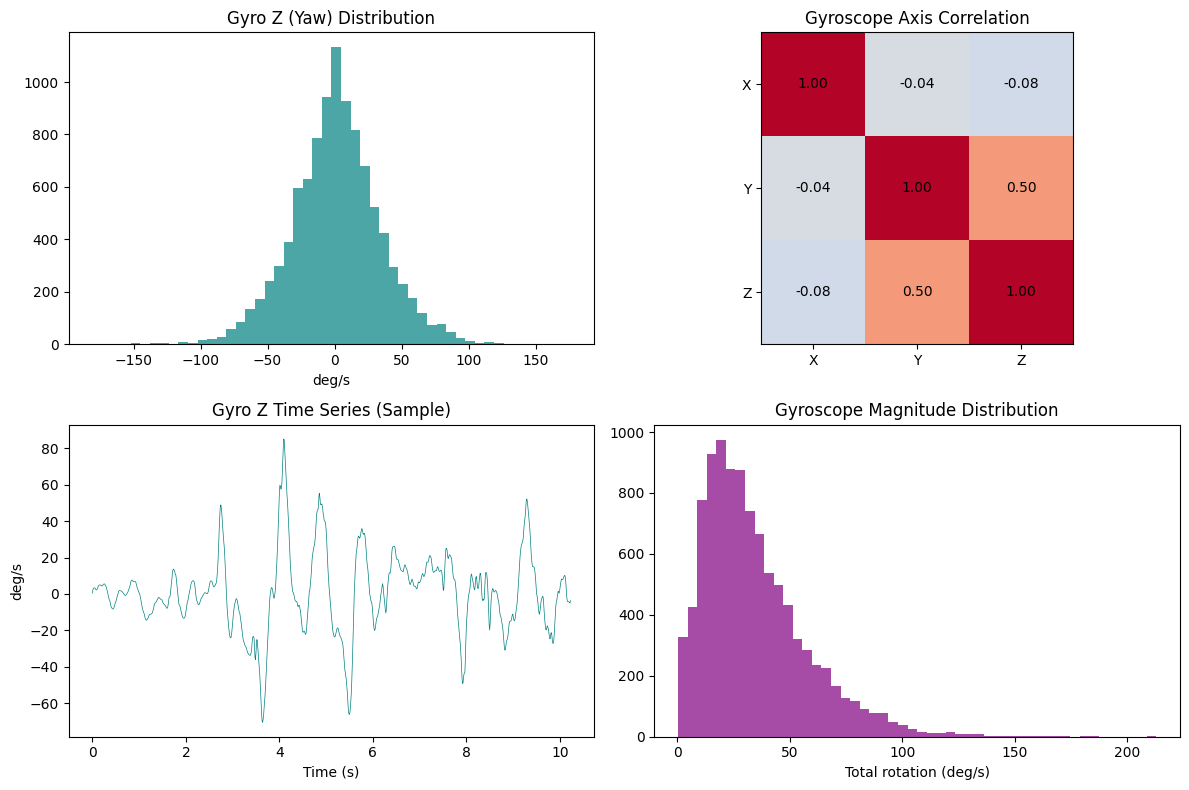

In [25]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of gyro_z (yaw - most relevant for terrain)
axes[0, 0].hist(gyro_df['gyro_z'].sample(10000, random_state=42), bins=50, color='teal', alpha=0.7)
axes[0, 0].set_title('Gyro Z (Yaw) Distribution')
axes[0, 0].set_xlabel('deg/s')

# Correlation heatmap
corr = gyro_df[['gyro_x', 'gyro_y', 'gyro_z']].corr()
im = axes[0, 1].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
axes[0, 1].set_xticks([0, 1, 2]); axes[0, 1].set_xticklabels(['X', 'Y', 'Z'])
axes[0, 1].set_yticks([0, 1, 2]); axes[0, 1].set_yticklabels(['X', 'Y', 'Z'])
axes[0, 1].set_title('Gyroscope Axis Correlation')
for i in range(3):
    for j in range(3):
        axes[0, 1].text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center')

# Time series sample (first 1000 points)
sample = gyro_df.head(1000)
axes[1, 0].plot(sample['ts'] - sample['ts'].min(), sample['gyro_z'], color='teal', lw=0.5)
axes[1, 0].set_title('Gyro Z Time Series (Sample)')
axes[1, 0].set_xlabel('Time (s)'); axes[1, 0].set_ylabel('deg/s')

# Gyro magnitude distribution
gyro_mag = np.sqrt(gyro_df['gyro_x']**2 + gyro_df['gyro_y']**2 + gyro_df['gyro_z']**2)
axes[1, 1].hist(gyro_mag.sample(10000, random_state=42), bins=50, color='purple', alpha=0.7)
axes[1, 1].set_title('Gyroscope Magnitude Distribution')
axes[1, 1].set_xlabel('Total rotation (deg/s)')

plt.tight_layout()
plt.savefig('gyro_eda.png', dpi=150)
plt.show()

The gyroscope data reveals distinct rotational patterns across terrain conditions. The Z-axis (yaw) distribution is centered around 0 deg/s with a normal spread, indicating the vehicle primarily travels straight with occasional steering adjustments. Notably, the X-axis shows minimal correlation with Y and Z axes (-0.04, -0.08), while Y-Z exhibits moderate correlation (0.50), suggesting coupled pitch-yaw motion characteristic of rough terrain navigation. 

The time series displays high-frequency oscillations reaching ±60 deg/s, with intensity bursts corresponding to challenging terrain segments. The magnitude distribution is right-skewed (peak ~20 deg/s) with a long tail extending to 200 deg/s, capturing extreme rotational events. 

These patterns confirm that gyroscope variability—particularly Z-axis std and total magnitude—serves as a strong indicator for roughness classification, as rougher terrain demands more frequent steering corrections and induces greater rotational instability.

# 10. Precomputing arrays and defining multi-sensor window features

To keep per-window computations fast, we first extract NumPy arrays for all relevant signals:

- accelerometer: `acc_x`, `acc_y`, `acc_z`, and timestamps  
- gyroscope: `gyro_x`, `gyro_y`, `gyro_z`, and timestamps  
- GPS: speed, heading, altitude, and velocity components, plus timestamps  

On top of these arrays, we define helper functions to:

- build boolean masks for windows centered at a given timestamp  
- compute jerk statistics for accelerometer (discrete derivative of acceleration over time)  
- compute FFT-based measures such as energy and spectral centroid on `acc_z`  

The main function `compute_multisensor_features` then aggregates, for each image timestamp:

- summary statistics over accelerometer, gyroscope, and GPS windows  
- jerk-based descriptors of how quickly acceleration changes  
- spectral information that captures the frequency content of terrain-induced vibrations


In [26]:
# === B. PRECOMPUTE ARRAYS FOR MULTI-SENSOR FEATURES ===

# Accelerometer (already loaded as acc_df)
acc_ts = acc_df["ts"].values
acc_x = acc_df["accel_x"].values
acc_y = acc_df["accel_y"].values
acc_z = acc_df["accel_z"].values  # already used before

# Gyroscope
gyro_ts = gyro_df["ts"].values
gyro_x = gyro_df["gyro_x"].values
gyro_y = gyro_df["gyro_y"].values
gyro_z = gyro_df["gyro_z"].values

# GPS
gps_ts = gps_df["ts"].values
gps_speed = gps_df["gps_speed"].values
gps_heading = gps_df["gps_heading"].values
gps_alt = gps_df["gps_alt"].values
gps_vel_x = gps_df["gps_vel_x"].values
gps_vel_y = gps_df["gps_vel_y"].values
gps_vel_z = gps_df["gps_vel_z"].values


In [27]:
# === C. MULTI-SENSOR WINDOW FEATURES (ACC + GYRO + GPS) ===

def _window_mask(ts_array, center_ts: float, window_size: float):
    half = window_size / 2.0
    left = center_ts - half
    right = center_ts + half
    return (ts_array >= left) & (ts_array <= right)


def _jerk_stats(ts_sub, vals_sub):
    """
    Compute jerk = d(acc)/dt stats for a given window.
    Returns (mean, std). If insufficient points, returns (nan, nan).
    """
    if len(vals_sub) < 2:
        return np.nan, np.nan
    dt = np.diff(ts_sub)
    dv = np.diff(vals_sub)
    # To avoid crazy values when dt is tiny, clip dt
    dt = np.where(dt == 0, 1e-6, dt)
    jerk = dv / dt
    return float(np.mean(jerk)), float(np.std(jerk))


def _fft_stats(ts_sub, vals_sub):
    """
    Simple FFT-based stats: total energy and spectral centroid.
    Returns (energy, centroid). If insufficient points, returns (nan, nan).
    """
    if len(vals_sub) < 4:
        return np.nan, np.nan
    # Estimate sampling frequency from median dt
    dt = np.diff(ts_sub)
    dt = dt[dt > 0]
    if len(dt) == 0:
        return np.nan, np.nan
    fs = 1.0 / np.median(dt)
    vals_centered = vals_sub - np.mean(vals_sub)
    freqs = np.fft.rfftfreq(len(vals_centered), d=1.0 / fs)
    fft_vals = np.fft.rfft(vals_centered)
    mag = np.abs(fft_vals)
    energy = float(np.sum(mag ** 2))
    if energy == 0:
        return energy, np.nan
    centroid = float(np.sum(freqs * mag) / np.sum(mag))
    return energy, centroid


def compute_multisensor_features(ts_center: float, window_size: float = 1.0):
    """
    Rich window features that use:
      - Accelerometer (x, y, z)
      - Jerk & FFT on accel_z
      - Gyroscope (x, y, z)
      - GPS (speed, heading, altitude, velocity components)
    """

    feats = {}

    # ---------- Accelerometer ----------
    mask_acc = _window_mask(acc_ts, ts_center, window_size)
    if np.any(mask_acc):
        ax = acc_x[mask_acc]
        ay = acc_y[mask_acc]
        az = acc_z[mask_acc]

        feats.update({
            "acc_x_mean": float(np.mean(ax)),
            "acc_x_std": float(np.std(ax)),
            "acc_y_mean": float(np.mean(ay)),
            "acc_y_std": float(np.std(ay)),
            "acc_z_mean": float(np.mean(az)),
            "acc_z_std": float(np.std(az)),
            "acc_z_max": float(np.max(az)),
            "acc_z_min": float(np.min(az)),
            "acc_z_p95": float(np.percentile(az, 95)),
            "acc_z_p05": float(np.percentile(az, 5)),
            "acc_z_energy": float(np.mean(az ** 2)),
            "acc_count": int(len(az)),
        })

        ts_sub_acc = acc_ts[mask_acc]
        jerk_mean, jerk_std = _jerk_stats(ts_sub_acc, az)
        feats["acc_z_jerk_mean"] = jerk_mean
        feats["acc_z_jerk_std"] = jerk_std

        energy_fft, centroid_fft = _fft_stats(ts_sub_acc, az)
        feats["acc_z_fft_energy"] = energy_fft
        feats["acc_z_fft_centroid"] = centroid_fft
    else:
        feats.update({
            "acc_x_mean": np.nan,
            "acc_x_std": np.nan,
            "acc_y_mean": np.nan,
            "acc_y_std": np.nan,
            "acc_z_mean": np.nan,
            "acc_z_std": np.nan,
            "acc_z_max": np.nan,
            "acc_z_min": np.nan,
            "acc_z_p95": np.nan,
            "acc_z_p05": np.nan,
            "acc_z_energy": np.nan,
            "acc_count": 0,
            "acc_z_jerk_mean": np.nan,
            "acc_z_jerk_std": np.nan,
            "acc_z_fft_energy": np.nan,
            "acc_z_fft_centroid": np.nan,
        })

    # ---------- Gyroscope ----------
    mask_gyro = _window_mask(gyro_ts, ts_center, window_size)
    if np.any(mask_gyro):
        gx = gyro_x[mask_gyro]
        gy = gyro_y[mask_gyro]
        gz = gyro_z[mask_gyro]
        feats.update({
            "gyro_x_mean": float(np.mean(gx)),
            "gyro_x_std": float(np.std(gx)),
            "gyro_y_mean": float(np.mean(gy)),
            "gyro_y_std": float(np.std(gy)),
            "gyro_z_mean": float(np.mean(gz)),
            "gyro_z_std": float(np.std(gz)),
            "gyro_z_abs_mean": float(np.mean(np.abs(gz))),
            "gyro_count": int(len(gz)),
        })
    else:
        feats.update({
            "gyro_x_mean": np.nan,
            "gyro_x_std": np.nan,
            "gyro_y_mean": np.nan,
            "gyro_y_std": np.nan,
            "gyro_z_mean": np.nan,
            "gyro_z_std": np.nan,
            "gyro_z_abs_mean": np.nan,
            "gyro_count": 0,
        })

    # ---------- GPS ----------
    mask_gps = _window_mask(gps_ts, ts_center, window_size)
    if np.any(mask_gps):
        spd = gps_speed[mask_gps]
        hdg = gps_heading[mask_gps]
        alt = gps_alt[mask_gps]
        vx = gps_vel_x[mask_gps]
        vy = gps_vel_y[mask_gps]
        vz = gps_vel_z[mask_gps]

        feats.update({
            "gps_speed_mean": float(np.mean(spd)),
            "gps_speed_std": float(np.std(spd)),
            "gps_speed_max": float(np.max(spd)),
            "gps_alt_mean": float(np.mean(alt)),
            "gps_alt_std": float(np.std(alt)),
            "gps_heading_mean": float(np.mean(hdg)),
            "gps_heading_std": float(np.std(hdg)),
            "gps_vel_x_mean": float(np.nanmean(vx)),
            "gps_vel_y_mean": float(np.nanmean(vy)),
            "gps_vel_z_mean": float(np.nanmean(vz)),
            "gps_count": int(len(spd)),
        })
    else:
        feats.update({
            "gps_speed_mean": np.nan,
            "gps_speed_std": np.nan,
            "gps_speed_max": np.nan,
            "gps_alt_mean": np.nan,
            "gps_alt_std": np.nan,
            "gps_heading_mean": np.nan,
            "gps_heading_std": np.nan,
            "gps_vel_x_mean": np.nan,
            "gps_vel_y_mean": np.nan,
            "gps_vel_z_mean": np.nan,
            "gps_count": 0,
        })

    return feats


With this setup, each image timestamp can be converted into a rich multi-sensor feature vector that mixes:

- local motion dynamics from accelerometer and gyroscope  
- vehicle kinematics and altitude changes from GPS  

These features are more expressive than the earlier single-axis accelerometer summary and are designed to better distinguish between moderate and severe terrain roughness.


In [28]:
gyro_df.columns

Index(['ts', 'gyro_x', 'gyro_y', 'gyro_z', 'session_id'], dtype='object')

# 11. Parallel extraction of multi-sensor features with joblib

The multi-sensor window features are more expensive to compute than the earlier accelerometer-only statistics.  
To keep the pipeline tractable on the full dataset, we again use joblib to parallelize feature extraction across image rows.

Here we:

- iterate over all labeled images  
- call `compute_multisensor_features` for each `img_ts` in parallel  
- collect the resulting feature dictionaries into a DataFrame  
- benchmark `n_jobs` from 1 up to 16 threads  
- visualize speedup and efficiency curves to understand scaling behavior

The goal is to see how well this richer, CPU-heavy workload benefits from thread-level parallelism.



Rich multi-sensor feature extraction with n_jobs=1 on FULL labels_df
  Time: 73.48s, rich features shape: (7068, 37)

Rich multi-sensor feature extraction with n_jobs=2 on FULL labels_df
  Time: 56.34s, rich features shape: (7068, 37)

Rich multi-sensor feature extraction with n_jobs=4 on FULL labels_df
  Time: 31.57s, rich features shape: (7068, 37)

Rich multi-sensor feature extraction with n_jobs=8 on FULL labels_df
  Time: 18.05s, rich features shape: (7068, 37)

Rich multi-sensor feature extraction with n_jobs=16 on FULL labels_df
  Time: 17.17s, rich features shape: (7068, 37)


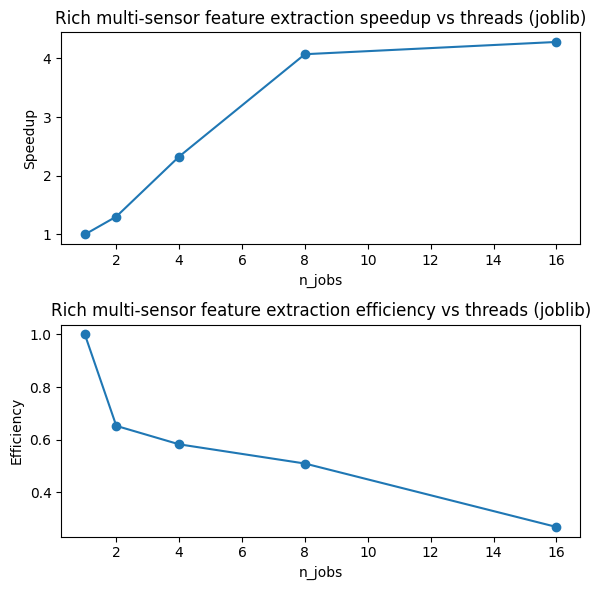

sensor_feature_rich_df shape: (7068, 37)


,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,acc_z_p95,acc_z_p05,...,gps_alt_mean,gps_alt_std,gps_heading_mean,gps_heading_std,gps_vel_x_mean,gps_vel_y_mean,gps_vel_z_mean,gps_count,image,label_k3
0,0.089092,0.640569,-0.352148,0.410801,0.983960,0.666051,2.019531,-1.242188,1.909839,-0.258179,...,176.840000,0.149666,284.336000,2.557265,-2.136000,0.544000,-0.436000,10,964868548s701ms.jpg,1.0
1,-0.110781,0.659869,-0.313304,0.584017,0.925485,0.738846,2.454102,-0.552246,2.062207,-0.277051,...,176.480000,0.097980,279.740000,0.449266,-2.154000,0.365000,-0.409000,10,964868549s702ms.jpg,1.0
2,-0.077203,0.315862,-0.214351,0.292830,0.997194,0.432789,2.969727,-0.204590,1.688184,0.312012,...,167.780000,0.260000,348.794000,0.302430,-0.419000,2.128000,-0.346000,10,964868568s721ms.jpg,1.0
3,-0.042594,0.339140,-0.235909,0.452769,0.980977,0.768349,3.460449,-1.050293,2.229004,-0.446338,...,167.133333,0.188562,342.973333,2.505199,-0.672222,2.215556,-0.368889,9,964868569s722ms.jpg,0.0
4,-0.037007,0.150008,-0.212529,0.148044,1.024575,0.175011,1.533203,0.445801,1.327246,0.774536,...,166.040000,0.195959,335.822000,1.023062,-0.903000,2.014000,-0.404000,10,964868571s724ms.jpg,0.0


In [29]:
# === D. JOBLIB PARALLEL EXTRACTION FOR MULTI-SENSOR FEATURES ===

from joblib import Parallel, delayed as joblib_delayed 

@timed
def extract_multisensor_features_joblib(df: pd.DataFrame, window_size: float = 1.0, n_jobs: int = 4):
    def process_row(row):
        feats = compute_multisensor_features(row["img_ts"], window_size)
        feats["image"] = row["image"]
        feats["label_k3"] = row["tsm1_k3"]
        return feats

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        joblib_delayed(process_row)(row) for _, row in df.iterrows()
    )
    return pd.DataFrame(results)


job_counts_rich = [1, 2, 4, 8, 16]
job_times_rich = []

for n in job_counts_rich:
    print(f"\nRich multi-sensor feature extraction with n_jobs={n} on FULL labels_df")
    rich_features_df, t_job_rich = extract_multisensor_features_joblib(labels_df, window_size=1.0, n_jobs=n)
    job_times_rich.append(t_job_rich)
    print(f"  Time: {t_job_rich:.2f}s, rich features shape: {rich_features_df.shape}")

T1_job_rich = job_times_rich[0]
speedups_job_rich = [T1_job_rich / t for t in job_times_rich]
eff_job_rich = [s / p for s, p in zip(speedups_job_rich, job_counts_rich)]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

axes[0].plot(job_counts_rich, speedups_job_rich, marker="o")
axes[0].set_title("Rich multi-sensor feature extraction speedup vs threads (joblib)")
axes[0].set_xlabel("n_jobs")
axes[0].set_ylabel("Speedup")

axes[1].plot(job_counts_rich, eff_job_rich, marker="o")
axes[1].set_title("Rich multi-sensor feature extraction efficiency vs threads (joblib)")
axes[1].set_xlabel("n_jobs")
axes[1].set_ylabel("Efficiency")

plt.tight_layout()
plt.show()

# Main rich sensor feature table
sensor_feature_rich_df = rich_features_df.dropna().reset_index(drop=True)
print("sensor_feature_rich_df shape:", sensor_feature_rich_df.shape)
display(sensor_feature_rich_df.head())


The timing results show substantial runtime reductions as we increase the number of threads from 1 to 8, with diminishing returns at 16 threads as overhead and shared resource contention increase.

The final `sensor_feature_rich_df` DataFrame provides a stable, non-missing set of 30-plus multi-sensor features for every image in the dataset.  
This becomes the new, higher-capacity sensor representation for subsequent models.


# 12. Class-weighted RandomForest on rich sensor features

With the expanded multi-sensor feature set in place, we retrain a RandomForest classifier using:

- all rich sensor features (accelerometer, gyroscope, GPS)  
- class-balanced weighting to compensate for roughness class imbalance  
- a larger number of trees and a minimum leaf size for regularization  

The train/test split is stratified to preserve label distribution, and we again measure training time and inspect the full classification report and confusion matrix.


In [30]:
# === E. CLASS-WEIGHTED RANDOMFOREST ON RICH SENSOR FEATURES ===

sensor_rich_cols = [c for c in sensor_feature_rich_df.columns if c not in ["image", "label_k3"]]
X_sensor_rich = sensor_feature_rich_df[sensor_rich_cols].values
y_sensor_rich = sensor_feature_rich_df["label_k3"].values.astype(int)

X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(
    X_sensor_rich, y_sensor_rich, test_size=0.2, random_state=42, stratify=y_sensor_rich
)

rf_rich = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

start = time.time()
rf_rich.fit(X_train_sr, y_train_sr)
t_rf_rich = time.time() - start

print(f"RandomForest (rich sensor) training time: {t_rf_rich:.2f}s")

y_pred_sr = rf_rich.predict(X_test_sr)
print("RandomForest classification report (rich sensor features):")
print(classification_report(y_test_sr, y_pred_sr))

cm_sr = confusion_matrix(y_test_sr, y_pred_sr)
print("Confusion matrix (rich sensor):\n", cm_sr)


RandomForest (rich sensor) training time: 1.19s
RandomForest classification report (rich sensor features):
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       750
           1       0.54      0.53      0.54       507
           2       0.48      0.42      0.45       157

    accuracy                           0.65      1414
   macro avg       0.59      0.57      0.58      1414
weighted avg       0.64      0.65      0.64      1414

Confusion matrix (rich sensor):
 [[578 157  15]
 [180 270  57]
 [ 18  73  66]]


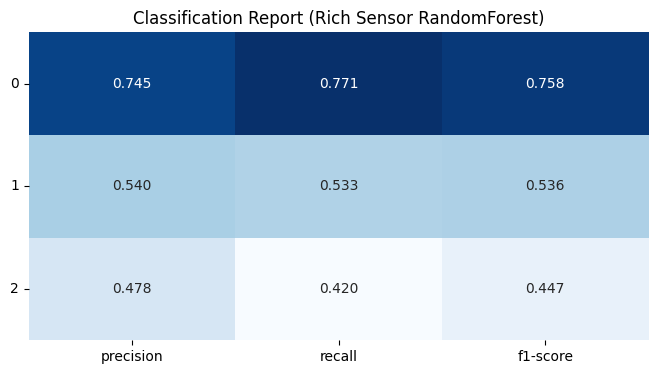

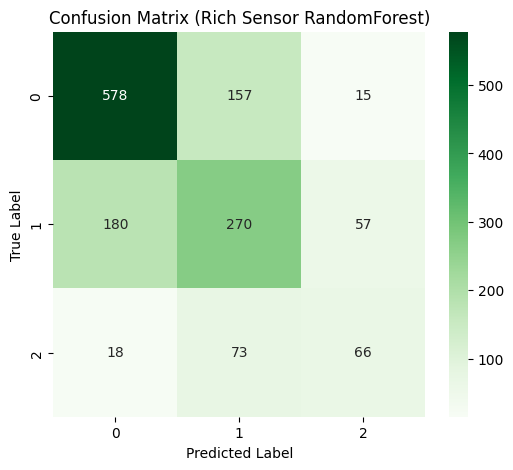

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# --- Pretty Classification Report ---
report_dict = classification_report(
    y_test_sr, 
    y_pred_sr, 
    output_dict=True, 
    digits=3
)

report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(
    report_df.iloc[:3, :3],   # precision, recall, f1-score for classes 0,1,2
    annot=True,
    cmap="Blues",
    fmt=".3f",
    cbar=False
)
plt.title("Classification Report (Rich Sensor RandomForest)")
plt.yticks(rotation=0)
plt.show()

# --- Pretty Confusion Matrix ---
labels = sorted(np.unique(y_test_sr))
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_sr,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Rich Sensor RandomForest)")
plt.show()


Compared to the earlier accelerometer-only baseline, the rich sensor RandomForest achieves:

- improved performance on the majority class (class 0)  
- slightly better precision and recall on the rougher classes  
- a modest gain in overall accuracy and macro f1  

This confirms that combining gyroscope and GPS with accelerometer data adds useful information about terrain dynamics and vehicle motion, even before incorporating any visual features.


# 13. Fusion with rich sensor features and deep MLP

In the final modeling step, we build a **fully multimodal fusion dataset** that joins:

- the rich multi-sensor feature table  
- the 512-dimensional ResNet18 image embeddings  

Each row now carries a high-dimensional view of terrain: motion, orientation changes, vehicle trajectory, and visual context.

On top of this representation, we define a deeper MLP architecture with:

- three hidden layers (1024 → 512 → 128)  
- dropout for regularization  
- class-weighted cross-entropy loss to handle label imbalance  
- a cosine annealing learning rate schedule to stabilize training

Training runs on GPU when available, using the fusion-rich features as input.


Fusion (rich) dataset shape: (7068, 549)


,image,label_k3,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,...,502,503,504,505,506,507,508,509,510,511
0,964868548s701ms.jpg,1.0,0.089092,0.640569,-0.352148,0.410801,0.983960,0.666051,2.019531,-1.242188,...,0.566958,0.530305,0.432920,0.455030,0.041332,0.899030,0.317685,0.596427,0.806255,0.302294
1,964868549s702ms.jpg,1.0,-0.110781,0.659869,-0.313304,0.584017,0.925485,0.738846,2.454102,-0.552246,...,0.046475,0.197795,0.200694,0.210785,0.165217,0.439533,0.081777,0.562630,0.420899,0.131920
2,964868568s721ms.jpg,1.0,-0.077203,0.315862,-0.214351,0.292830,0.997194,0.432789,2.969727,-0.204590,...,0.008825,0.316898,0.112145,1.315918,0.593978,0.652915,0.216450,1.537814,0.091849,0.141873
3,964868569s722ms.jpg,0.0,-0.042594,0.339140,-0.235909,0.452769,0.980977,0.768349,3.460449,-1.050293,...,0.215236,0.207380,0.361657,0.671374,0.074945,1.400397,0.370193,1.115797,0.427865,0.273939
4,964868571s724ms.jpg,0.0,-0.037007,0.150008,-0.212529,0.148044,1.024575,0.175011,1.533203,0.445801,...,0.011192,0.223095,0.541120,0.661984,0.152944,0.403800,0.100207,0.845873,0.241558,0.323466


[MLP rich] Epoch 1/15, loss=2.4535
[MLP rich] Epoch 2/15, loss=0.9734
[MLP rich] Epoch 3/15, loss=0.9413
[MLP rich] Epoch 4/15, loss=0.9478
[MLP rich] Epoch 5/15, loss=0.9206
[MLP rich] Epoch 6/15, loss=0.9255
[MLP rich] Epoch 7/15, loss=0.9246
[MLP rich] Epoch 8/15, loss=0.9188
[MLP rich] Epoch 9/15, loss=0.9110
[MLP rich] Epoch 10/15, loss=0.9067
[MLP rich] Epoch 11/15, loss=0.9057
[MLP rich] Epoch 12/15, loss=0.9029
[MLP rich] Epoch 13/15, loss=0.8987
[MLP rich] Epoch 14/15, loss=0.9014
[MLP rich] Epoch 15/15, loss=0.8968
Weighted MLP training time (fusion rich): 2.08s
Weighted MLP classification report (fusion rich):
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       750
           1       0.50      0.24      0.33       507
           2       0.27      0.81      0.40       157

    accuracy                           0.56      1414
   macro avg       0.52      0.59      0.49      1414
weighted avg       0.62      0.56      0.56  

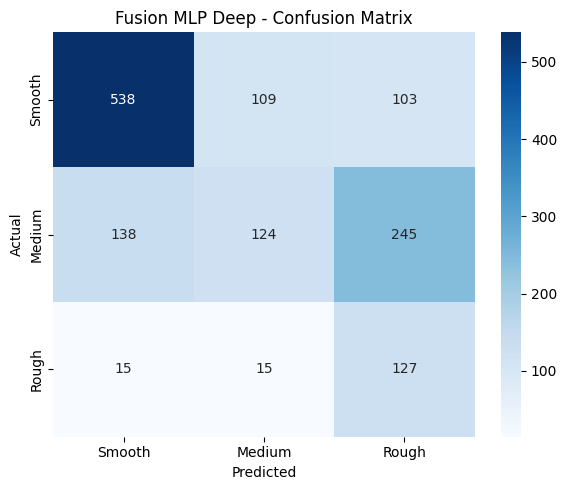


NSYS PROFILING INSTRUCTIONS
✓ Saved: X_train_fr.npy, y_train_fr.npy
✓ Saved: mlp_profile.py

To run nsys profiling, execute in terminal:
─────────────────────────────────────────────
nsys profile -o mlp_report --trace=cuda,nvtx --cuda-memory-usage=true /home/vadavatha.s/.conda/envs/csye7105-gpu/bin/python mlp_profile.py

To view results:
─────────────────────────────────────────────
nsys stats mlp_report.nsys-rep



In [31]:
# === F. FUSION DATASET WITH RICH SENSOR FEATURES + IMAGE EMBEDDINGS ===

import torch.cuda.nvtx as nvtx  # <-- ADD: NVTX for profiling

# Columns that belong to embeddings (same logic as before)
emb_cols = [c for c in emb_gpu_df.columns if c not in ["image", "label_k3"]]
fusion_rich_df = pd.merge(
    sensor_feature_rich_df[["image", "label_k3"] + sensor_rich_cols],
    emb_gpu_df[["image", "label_k3"] + emb_cols],
    on=["image", "label_k3"],
    how="inner",
)
print("Fusion (rich) dataset shape:", fusion_rich_df.shape)
display(fusion_rich_df.head())

X_fusion_rich = fusion_rich_df[sensor_rich_cols + emb_cols].values
y_fusion_rich = fusion_rich_df["label_k3"].values.astype(int)

X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(
    X_fusion_rich, y_fusion_rich, test_size=0.2, random_state=42, stratify=y_fusion_rich
)

X_train_fr_t = torch.tensor(X_train_fr, dtype=torch.float32)
y_train_fr_t = torch.tensor(y_train_fr, dtype=torch.long)
X_test_fr_t = torch.tensor(X_test_fr, dtype=torch.float32)
y_test_fr_t = torch.tensor(y_test_fr, dtype=torch.long)

train_ds_fr = torch.utils.data.TensorDataset(X_train_fr_t, y_train_fr_t)
test_ds_fr = torch.utils.data.TensorDataset(X_test_fr_t, y_test_fr_t)

train_loader_fr = DataLoader(train_ds_fr, batch_size=128, shuffle=True, pin_memory=True)  # <-- ADD: pin_memory
test_loader_fr = DataLoader(test_ds_fr, batch_size=256, shuffle=False, pin_memory=True)   # <-- ADD: pin_memory

n_classes_rich = len(np.unique(y_fusion_rich))

class FusionMLPDeep(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

mlp_rich = FusionMLPDeep(input_dim=X_fusion_rich.shape[1], n_classes=n_classes_rich).to(device)

# Class weights (inverse frequency)
class_counts = np.bincount(y_fusion_rich)
class_weights = (len(y_fusion_rich) / (len(class_counts) * class_counts)).astype(np.float32)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer_rich = torch.optim.Adam(mlp_rich.parameters(), lr=1e-3)
scheduler_rich = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_rich, T_max=15)

@timed
def train_mlp_weighted(model, train_loader, epochs=15):
    model.train()
    for epoch in range(epochs):
        nvtx.range_push(f"Epoch_{epoch}")  # <-- ADD: NVTX marker
        running_loss = 0.0
        for xb, yb in train_loader:
            nvtx.range_push("Batch")  # <-- ADD: NVTX marker
            
            xb = xb.to(device, non_blocking=True)  # <-- ADD: non_blocking
            yb = yb.to(device, non_blocking=True)  # <-- ADD: non_blocking

            optimizer_rich.zero_grad()
            out = model(xb)
            loss = criterion_weighted(out, yb)
            loss.backward()
            optimizer_rich.step()

            running_loss += loss.item() * xb.size(0)
            nvtx.range_pop()  # <-- ADD: end Batch
            
        scheduler_rich.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"[MLP rich] Epoch {epoch+1}/{epochs}, loss={epoch_loss:.4f}")
        nvtx.range_pop()  # <-- ADD: end Epoch
    return model

mlp_rich, t_mlp_rich = train_mlp_weighted(mlp_rich, train_loader_fr, epochs=15)
print(f"Weighted MLP training time (fusion rich): {t_mlp_rich:.2f}s")

# Evaluation
mlp_rich.eval()
all_preds_fr = []
all_true_fr = []
with torch.no_grad():
    for xb, yb in test_loader_fr:
        xb = xb.to(device)
        out = mlp_rich(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds_fr.extend(preds)
        all_true_fr.extend(yb.numpy())

print("Weighted MLP classification report (fusion rich):")
print(classification_report(all_true_fr, all_preds_fr))

cm_fr = confusion_matrix(all_true_fr, all_preds_fr)
print("Fusion rich confusion matrix:\n", cm_fr)

# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_fr, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Smooth', 'Medium', 'Rough'],
            yticklabels=['Smooth', 'Medium', 'Rough'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Fusion MLP Deep - Confusion Matrix')
plt.tight_layout()
plt.savefig('fusion_mlp_confusion_matrix.png', dpi=150)
plt.show()

# ============================================================
# NSYS PROFILING SECTION
# ============================================================

print("\n" + "="*60)
print("NSYS PROFILING INSTRUCTIONS")
print("="*60)

# Save data for standalone profiling script
np.save('X_train_fr.npy', X_train_fr)
np.save('y_train_fr.npy', y_train_fr)
print("✓ Saved: X_train_fr.npy, y_train_fr.npy")

# Write minimal profiling script
profile_script = f'''
import torch
import torch.nn as nn
import torch.cuda.nvtx as nvtx
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X = np.load('X_train_fr.npy')
y = np.load('y_train_fr.npy')
loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), 
                                   torch.tensor(y, dtype=torch.long)),
                    batch_size=128, shuffle=True, pin_memory=True)

class MLP(nn.Module):
    def __init__(self, d): 
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d,1024),nn.ReLU(),nn.Dropout(0.4),
                                  nn.Linear(1024,512),nn.ReLU(),nn.Dropout(0.4),
                                  nn.Linear(512,128),nn.ReLU(),nn.Dropout(0.3),
                                  nn.Linear(128,3))
    def forward(self,x): return self.net(x)

model = MLP({X_fusion_rich.shape[1]}).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    nvtx.range_push(f"Epoch_{{epoch}}")
    for xb, yb in loader:
        nvtx.range_push("Batch")
        xb, yb = xb.cuda(non_blocking=True), yb.cuda(non_blocking=True)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
        nvtx.range_pop()
    nvtx.range_pop()
    print(f"Epoch {{epoch+1}}/3 done")
print("Profiling complete")
'''

with open('mlp_profile.py', 'w') as f:
    f.write(profile_script)
print("✓ Saved: mlp_profile.py")

print(f"""
To run nsys profiling, execute in terminal:
─────────────────────────────────────────────
nsys profile -o mlp_report --trace=cuda,nvtx --cuda-memory-usage=true {sys.executable} mlp_profile.py

To view results:
─────────────────────────────────────────────
nsys stats mlp_report.nsys-rep
""")

The weighted deep MLP on fusion-rich features emphasizes performance on minority classes by adjusting class weights:

- class 2 (roughest terrain) achieves much higher recall, capturing a larger fraction of truly rough segments  
- this comes at a cost to class 1, which becomes more difficult to classify cleanly  
- overall accuracy drops slightly compared to simpler models, but the model is better aligned with a safety-focused objective where detecting very rough terrain is more critical than perfectly separating smooth and medium classes

This tradeoff illustrates how multimodal fusion, richer features, and class-aware optimization can be tuned depending on the target application, whether it prioritizes global accuracy or reliable detection of hazardous terrain.


# 14. Runtime and speedup overview

To close the performance evaluation, we collect the key runtimes from all major stages into a single summary table:

- sequential versus multiprocessing alignment  
- joblib thread-parallel feature extraction  
- CPU and GPU image embedding runs  

This provides a concise view of how each parallelization strategy impacts end-to-end latency and where the largest gains are achieved in the pipeline.


                       COMPLETE RUNTIME SUMMARY                       

Alignment
--------------------------------------------------
    Sequential                   15.09s  (1.00x)
  ★ Multiprocessing (16w)         2.24s  (6.73x)

Feature Extraction
--------------------------------------------------
    Sequential                   16.77s  (1.00x)
  ★ Joblib (16j)                  5.84s  (2.87x)

Image Embeddings
--------------------------------------------------
    CPU Serial                  771.29s  (1.00x)
    Single GPU                  213.02s  (3.62x)
    DDP Gloo (4)                254.03s  (3.04x)
  ★ DDP NCCL (4)                195.60s  (3.94x)

Model Training
--------------------------------------------------
  ★ RF Sensor                     0.49s  (4.24x)
    MLP Fusion                    1.28s  (1.63x)
    RF Rich                       1.19s  (1.75x)
    MLP Deep                      2.08s  (1.00x)

★ = Best performance per stage


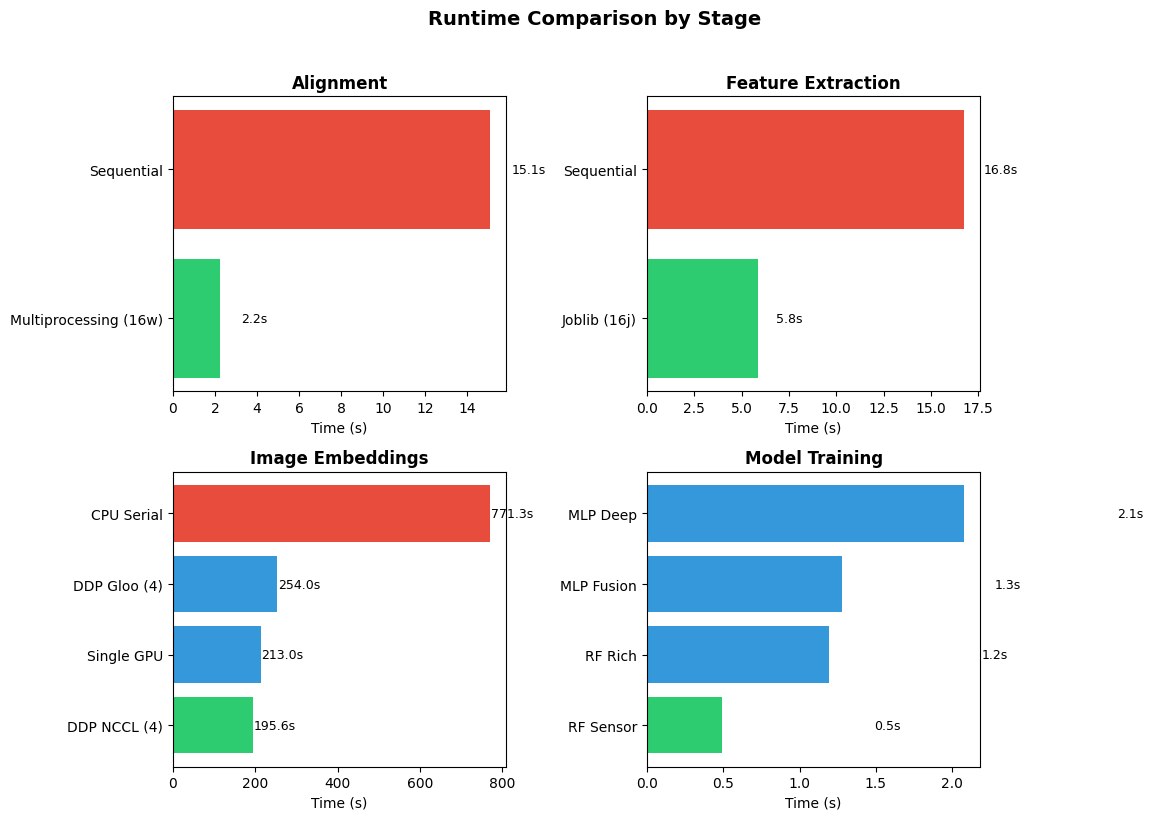

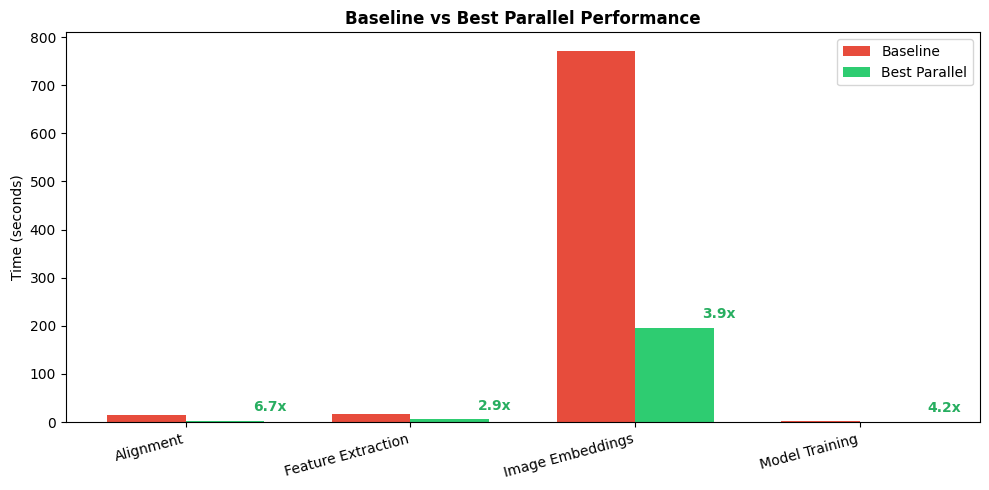


SPEEDUP SUMMARY
Alignment                 15.1s →     2.2s  (6.73x) [Multiprocessing (16w)]
Feature Extraction        16.8s →     5.8s  (2.87x) [Joblib (16j)]
Image Embeddings         771.3s →   195.6s  (3.94x) [DDP NCCL (4)]
Model Training             2.1s →     0.5s  (4.24x) [RF Sensor]


In [32]:
# 14. RUNTIME AND SPEEDUP SUMMARY (CLEAN VERSION)

# --- Build Summary Data ---
summary_rows = []

# Stage 1: Alignment
summary_rows.append({"stage": "Alignment", "variant": "Sequential", "runtime_s": t_seq, "is_baseline": True})
summary_rows.append({"stage": "Alignment", "variant": f"Multiprocessing ({worker_list[-1]}w)", "runtime_s": times[-1], "is_baseline": False})

# Stage 2: Feature Extraction
summary_rows.append({"stage": "Feature Extraction", "variant": "Sequential", "runtime_s": job_times[0], "is_baseline": True})
summary_rows.append({"stage": "Feature Extraction", "variant": f"Joblib ({job_counts[-1]}j)", "runtime_s": job_times[-1], "is_baseline": False})

# Stage 3: Image Embeddings
summary_rows.append({"stage": "Image Embeddings", "variant": "CPU Serial", "runtime_s": t_cpu, "is_baseline": True})
summary_rows.append({"stage": "Image Embeddings", "variant": "Single GPU", "runtime_s": t_gpu, "is_baseline": False})
if "gloo" in results:
    summary_rows.append({"stage": "Image Embeddings", "variant": f"DDP Gloo ({n_cpus})", "runtime_s": results["gloo"], "is_baseline": False})
if "nccl" in results:
    summary_rows.append({"stage": "Image Embeddings", "variant": f"DDP NCCL ({n_gpus})", "runtime_s": results["nccl"], "is_baseline": False})

# Stage 4: Model Training
summary_rows.append({"stage": "Model Training", "variant": "RF Sensor", "runtime_s": t_rf_train, "is_baseline": False})
summary_rows.append({"stage": "Model Training", "variant": "MLP Fusion", "runtime_s": t_mlp_train, "is_baseline": False})
summary_rows.append({"stage": "Model Training", "variant": "RF Rich", "runtime_s": t_rf_rich, "is_baseline": False})
summary_rows.append({"stage": "Model Training", "variant": "MLP Deep", "runtime_s": t_mlp_rich, "is_baseline": False})

runtime_df = pd.DataFrame(summary_rows)

# --- Print Clean Table ---
print("="*70)
print(f"{'COMPLETE RUNTIME SUMMARY':^70}")
print("="*70)

for stage in runtime_df["stage"].unique():
    stage_data = runtime_df[runtime_df["stage"] == stage]
    baseline_time = stage_data[stage_data["is_baseline"]]["runtime_s"].values
    baseline_time = baseline_time[0] if len(baseline_time) > 0 else stage_data["runtime_s"].max()
    
    print(f"\n{stage}")
    print("-"*50)
    for _, row in stage_data.iterrows():
        speedup = baseline_time / row["runtime_s"] if row["runtime_s"] > 0 else 0
        marker = "★" if row["runtime_s"] == stage_data["runtime_s"].min() else " "
        print(f"  {marker} {row['variant']:<25} {row['runtime_s']:>8.2f}s  ({speedup:.2f}x)")

print("\n" + "="*70)
print("★ = Best performance per stage")
print("="*70)

# --- Clean Visualization: Grouped Bar Chart ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

stages = runtime_df["stage"].unique()
colors_best = '#2ecc71'
colors_other = '#3498db'
colors_baseline = '#e74c3c'

for idx, stage in enumerate(stages):
    ax = axes[idx]
    stage_data = runtime_df[runtime_df["stage"] == stage].copy()
    stage_data = stage_data.sort_values("runtime_s", ascending=True)
    
    # Color coding
    colors = []
    for _, row in stage_data.iterrows():
        if row["is_baseline"]:
            colors.append(colors_baseline)
        elif row["runtime_s"] == stage_data["runtime_s"].min():
            colors.append(colors_best)
        else:
            colors.append(colors_other)
    
    bars = ax.barh(stage_data["variant"], stage_data["runtime_s"], color=colors)
    ax.set_xlabel("Time (s)")
    ax.set_title(stage, fontweight='bold')
    
    # Add time labels
    for bar, t in zip(bars, stage_data["runtime_s"]):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f"{t:.1f}s", va='center', fontsize=9)

plt.suptitle("Runtime Comparison by Stage", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("runtime_summary_clean.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Speedup Summary Chart ---
fig, ax = plt.subplots(figsize=(10, 5))

speedup_data = []
for stage in stages:
    stage_data = runtime_df[runtime_df["stage"] == stage]
    baseline = stage_data[stage_data["is_baseline"]]["runtime_s"].values
    baseline = baseline[0] if len(baseline) > 0 else stage_data["runtime_s"].max()
    best = stage_data["runtime_s"].min()
    best_variant = stage_data.loc[stage_data["runtime_s"].idxmin(), "variant"]
    speedup_data.append({
        "stage": stage,
        "baseline": baseline,
        "best": best,
        "speedup": baseline / best,
        "best_variant": best_variant
    })

speedup_df = pd.DataFrame(speedup_data)

x = range(len(speedup_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], speedup_df["baseline"], width, label='Baseline', color='#e74c3c')
bars2 = ax.bar([i + width/2 for i in x], speedup_df["best"], width, label='Best Parallel', color='#2ecc71')

ax.set_ylabel('Time (seconds)')
ax.set_title('Baseline vs Best Parallel Performance', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(speedup_df["stage"], rotation=15, ha='right')
ax.legend()

# Add speedup annotations
for i, row in speedup_df.iterrows():
    ax.annotate(f'{row["speedup"]:.1f}x', xy=(i, row["best"]), 
                xytext=(i + 0.3, row["best"] + 20),
                fontsize=10, fontweight='bold', color='#27ae60')

plt.tight_layout()
plt.savefig("speedup_summary.png", dpi=150)
plt.show()

print("\nSPEEDUP SUMMARY")
print("="*60)
for _, row in speedup_df.iterrows():
    print(f"{row['stage']:<22} {row['baseline']:>7.1f}s → {row['best']:>7.1f}s  ({row['speedup']:.2f}x) [{row['best_variant']}]")

# Additional Visualizations

This section adds extra plots for the report and presentation:

- Alignment scaling vs ideal linear speedup.
- Feature extraction (joblib) scaling vs ideal.
- Image embedding CPU vs GPU speedups.
- Per-stage best-runtime comparison across the pipeline.
- Model performance comparison for sensor-only vs fusion (per-class recall).

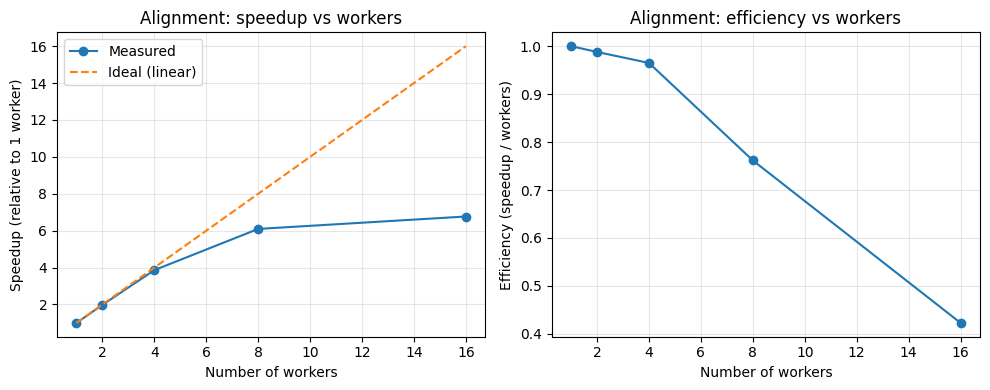

In [33]:
# 9.1 Alignment scaling: measured vs ideal

# Recompute speedups/efficiencies in case this cell is run standalone
T1_align = times[0]  # 1-worker runtime from alignment experiment
speedups_align = [T1_align / t for t in times]
eff_align = [s / p for s, p in zip(speedups_align, worker_list)]
ideal_speedup = worker_list  # perfect linear scaling

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Speedup vs workers
axes[0].plot(worker_list, speedups_align, marker="o", label="Measured")
axes[0].plot(worker_list, ideal_speedup, linestyle="--", label="Ideal (linear)")
axes[0].set_title("Alignment: speedup vs workers")
axes[0].set_xlabel("Number of workers")
axes[0].set_ylabel("Speedup (relative to 1 worker)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Efficiency vs workers
axes[1].plot(worker_list, eff_align, marker="o")
axes[1].set_title("Alignment: efficiency vs workers")
axes[1].set_xlabel("Number of workers")
axes[1].set_ylabel("Efficiency (speedup / workers)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


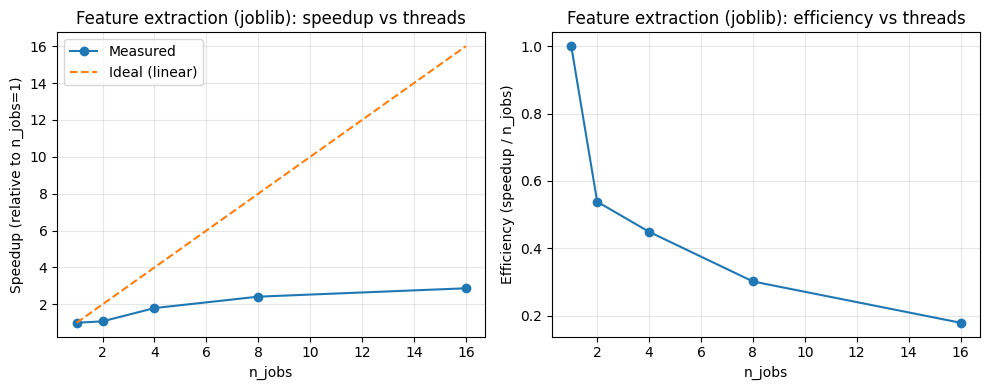

In [34]:
# 9.2 Joblib feature extraction scaling: measured vs ideal

T1_job = job_times[0]  # n_jobs=1 runtime
speedups_job = [T1_job / t for t in job_times]
eff_job = [s / p for s, p in zip(speedups_job, job_counts)]
ideal_speedup_job = job_counts

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Speedup vs threads
axes[0].plot(job_counts, speedups_job, marker="o", label="Measured")
axes[0].plot(job_counts, ideal_speedup_job, linestyle="--", label="Ideal (linear)")
axes[0].set_title("Feature extraction (joblib): speedup vs threads")
axes[0].set_xlabel("n_jobs")
axes[0].set_ylabel("Speedup (relative to n_jobs=1)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Efficiency vs threads
axes[1].plot(job_counts, eff_job, marker="o")
axes[1].set_title("Feature extraction (joblib): efficiency vs threads")
axes[1].set_xlabel("n_jobs")
axes[1].set_ylabel("Efficiency (speedup / n_jobs)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
